##### This notebook characterizes basic behavior and shared fits over all data. 

Updated to included analyses for eLife VoR.

Produces visuals/analyses for figures 2-3,6-8, fig 6 - Supplement 2.

Normative evidence weighting and accumulation in correlated environments. Tardiff et al. (2025).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import pickle
import copy
import itertools
from matplotlib import rc as rcmat
from os import path
from datetime import date
from itertools import product
from ddm import Sample
from ddm.functions import fit_adjust_model, display_model, solve_partial_conditions
import models_corr
import helpers
import gddmwrapper as gdw
import ddm_corr_subj as ddm_corr
from ddm import set_N_cpus

%config InlineBackend.figure_formats = ['svg']

In [2]:
#global style settings
rcmat('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.labelsize"] = 11.0 #supxlabel/supylabel
plt.rcParams["figure.titlesize"] = 12.0 #title/suptitle
plt.rcParams['legend.fontsize'] = 8.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'custom' #so uses same font as normal text for math/symbols

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
set_N_cpus(4)
fit_dir = './data/fits'
fig_dir = './Manuscript/Figure set draft/figs_raw'
data_dir = './data/'
data_files = {0.2:'r02_May10_parsed_data.csv',
              0.4:'r04_Apr8_Apr11_parsed_data.csv',
              0.6:'r06_Jan11_Jan17_Apr6_parsed_data.csv',
              0.8:'r08_Apr7_parsed_data.csv'}

cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.5,0.5,0.5,1.0),cmap[-1]]))

#we'll use this
idx = pd.IndexSlice
cm = 1/2.54  # centimeters in inches

In [4]:
#helper function for figure sizing
#from:https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


#plot fits for all subjects
def plot_psycho_chrono_subj(psychodf,chronodf,r_colors=r_colors,medianRT=False,mod_suffix=[''],mod_line=['-'],alpha=1,
                           RT_err=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    for (s,d),(_,dc) in zip(psychodf.groupby('subject'),chronodf.groupby('subject')):
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
        d.reset_index(level='subject',drop=True,inplace=True)
        dc.reset_index(level='subject',drop=True,inplace=True)
        for (r,dd),(rr,ddc) in zip(d.groupby('rho'),dc.groupby('rho')):
            #plot psycho
            assert r==rr
            r_col = np.sign(r) if multi_cond else r
            #print(r)
            dd.index=dd.index.droplevel(['rho','mu'])
            ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                            marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
            for m,l in zip(mod_suffix,mod_line):
                ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

            set_size(8,3,ax[0])
            ax[0].legend()
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')
            ax[0].set_title(s)

            #plot chrono
            ddc.index=ddc.index.droplevel(['rho','mu'])
            chrono_corr = ddc.xs(1.0,level='correct')
            chrono_err = ddc.xs(0.0,level='correct')

            if medianRT:
                ax[1].plot(chrono_corr['RT']['median'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
            else:
                ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                
            for m,l in zip(mod_suffix,mod_line):
                ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col])
                
            set_size(8,3,ax[1])
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
            
            if RT_err:
                if medianRT:
                    ax[2].plot(chrono_err['RT']['median'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
                else:
                    ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                                   marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                for m,l in zip(mod_suffix,mod_line):
                    ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
                set_size(8,3,ax[2])
            
def plot_psycho_chrono_ave(psychodf,chronodf,r_colors=r_colors,mod_suffix=[''],mod_line=['-'],alpha=1,RT_err=True,
                           ax=None,ax_labels=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    if ax is None:
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
    else:
        fig = None
                
    for (r,dd),(rr,ddc) in zip(psychodf.groupby('rho'),chronodf.groupby('rho')):
        #plot psycho
        assert r==rr
        r_col = np.sign(r) if multi_cond else r
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        #ax[0].plot(dd.index,dd['pred_response']['mean'],linestyle='-',color=r_colors[r_col])
        for m,l in zip(mod_suffix,mod_line):
            ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

        set_size(12,4,ax[0])
        ax[0].legend()
        if ax_labels:
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')

        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        chrono_err = ddc.xs(0.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        
        for m,l in zip(mod_suffix,mod_line):
            ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
        set_size(12,4,ax[1])
        if ax_labels:
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
        
        if RT_err:
            ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                           marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)

            for m,l in zip(mod_suffix,mod_line):
                ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
            if ax_labels:
                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
            set_size(12,4,ax[2])
    
    return ax if fig is None else fig,ax

In [5]:
#define functions for averaging over correlations
def meanzr(x):
    z = x.apply(lambda i: models_corr.fisherz(i)).mean()
    return models_corr.fishezr(z)


#I think this is the proper way to do SEM, but boy is it a lot of extra effort for very little difference
def semzr(x,ret=None):
    z = x.apply(lambda i: models_corr.fisherz(i))
    zmean = z.mean()
    zsd = z.std()
    zsem = zsd/np.sqrt(len(z))

    zbounds = np.array([zmean-zsem,zmean+zsem])
    zsem_asym = np.abs(models_corr.fishezr(zbounds)-models_corr.fishezr(zmean))
    
    if ret<2:
        return zsem_asym[ret]
    else:
        return zsem_asym

#SEM
def sem_low(x):
    return semzr(x,0)
def sem_high(x):
    return semzr(x,1)

In [6]:
#read in data
data = {}
for r,f in data_files.items():
    data[r] = pd.read_csv(path.join(data_dir,f))
    data[r]['rho_cond'] = r

data = pd.concat(data.values(),ignore_index=True)

#there shouldn't be any missing data from these files but let's check
assert not data.isnull().values.any(), "Missing data detected!"
display(data.head())

#now let's clean up column names
data.rename(columns={'Unnamed: 0':'trial','r':'rho','MeanMain':'mu','participant':'subject','SNR':'SNRraw'},inplace=True)
data.drop('index',axis=1,inplace=True)

#let's fix the trial column so it is actually reflecting trial numbers reset per subject
data['trial'] = np.int32(data.groupby('subject')['trial'].rank())
display(data.head())

subj = data[['subject','rho_cond']].drop_duplicates().sort_values('subject')
subj.reset_index(inplace=True,drop=True)
display(subj)
print(len(subj))
print(subj.rho_cond.value_counts())
assert not subj.subject.duplicated().any()

,Unnamed: 0,index,participant,r,MeanMain,RT,response,correct,SNR,threshold,rho_cond
0,0,5993,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,1,6004,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,2,6017,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,3,6030,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,4,6048,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,subject,rho_cond
0,575f387c91f8b40006c332e1,0.4
1,58f82417edbd82000169bce8,0.8
2,5b232f6838fc0c000131438c,0.6
3,5b3455bf532e3d00018e6e8b,0.8
4,5b477fdb56e0140001ac7720,0.8
...,...,...
95,61636a4bf1a773cc305502e7,0.6
96,616e401a1a88b28ca7581bb6,0.2
97,616f469494656434f5b4ebc6,0.2
98,6172eebe85de20b0b268d5c5,0.4


100
0.4    25
0.8    25
0.6    25
0.2    25
Name: rho_cond, dtype: int64


In [7]:
#SNR cleanup
subj_SNR_raw=data[['subject','rho','SNRraw']].drop_duplicates().sort_values(['subject','rho','SNRraw'])
assert ((subj_SNR_raw.reset_index().groupby(['subject','rho'])['SNRraw'].transform(lambda x: len(x))==4).all()), \
    'Too many SNRs detected for some subjects!'
subj_SNR_raw['rSNR']=subj_SNR_raw.groupby(['subject','rho']).rank()
#display(subj_SNR_raw.iloc[0:20])

#since there is floating-point slop between rho conds that is not fully alleviated by rounding, 
#we'll average over all rho conds to get a master set of SNR values
subj_SNR_raw=subj_SNR_raw.merge(subj_SNR_raw.groupby(['subject','rSNR'])[['SNRraw']].mean().round(2).rename({'SNRraw':'SNR'},axis=1),
                        on=['subject','rSNR']).sort_values(['subject','rho','SNR']).copy()

display(subj_SNR_raw.iloc[0:17])

#merge SNR back into data
print(data.shape)
data = data.merge(subj_SNR_raw.drop('rSNR',axis=1),on=['subject','rho','SNRraw'],how='left')
print(data.shape)
display(data)
assert (data.SNR-data.SNRraw < .006).all(), "rounded SNRs not properly joined to data!"

,subject,rho,SNRraw,rSNR,SNR
0,575f387c91f8b40006c332e1,-0.4,-0.748167,1.0,-0.75
3,575f387c91f8b40006c332e1,-0.4,-0.119707,2.0,-0.12
6,575f387c91f8b40006c332e1,-0.4,0.119707,3.0,0.12
9,575f387c91f8b40006c332e1,-0.4,0.748167,4.0,0.75
1,575f387c91f8b40006c332e1,0.0,-0.748225,1.0,-0.75
4,575f387c91f8b40006c332e1,0.0,-0.119716,2.0,-0.12
7,575f387c91f8b40006c332e1,0.0,0.119716,3.0,0.12
10,575f387c91f8b40006c332e1,0.0,0.748225,4.0,0.75
2,575f387c91f8b40006c332e1,0.4,-0.748398,1.0,-0.75
5,575f387c91f8b40006c332e1,0.4,-0.119720,2.0,-0.12


(76757, 10)
(76757, 11)


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2,-0.89
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2,-0.14
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2,0.14
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2,-0.14
...,...,...,...,...,...,...,...,...,...,...,...
76752,764,5e95d4f551598d01d6d455af,-0.8,-0.00788,3.7340,0.0,1.0,-0.124189,0.310849,0.8,-0.12
76753,765,5e95d4f551598d01d6d455af,0.8,0.05914,1.1230,1.0,1.0,0.777231,0.310849,0.8,0.78
76754,766,5e95d4f551598d01d6d455af,-0.8,0.00788,4.8250,0.0,0.0,0.124189,0.310849,0.8,0.12
76755,767,5e95d4f551598d01d6d455af,0.8,-0.05914,0.4020,0.0,1.0,-0.777231,0.310849,0.8,-0.78


In [8]:
#create SNR key by dropping duplicates
subj_SNR = subj_SNR_raw.drop(['rho','SNRraw'],axis=1).drop_duplicates()
#display(subj_SNR)

#add a universal SNR for aggregate data
subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),
                        on='rSNR').sort_values(['subject','uSNR']).copy()

#gut checks
assert (subj_SNR.value_counts().groupby('subject').sum()==4).all(), "Incorrect number of SNRs per subject!"
assert len(subj_SNR['subject'].drop_duplicates()) == len(subj), \
    "Subject mismatch between data and subj_SNR!"
assert np.array_equal(subj_SNR.loc[subj_SNR.rSNR==1,'SNR'].abs().values,subj_SNR.loc[subj_SNR.rSNR==4,'SNR'].values) and \
    np.array_equal(subj_SNR.loc[subj_SNR.rSNR==2,'SNR'].abs().values,subj_SNR.loc[subj_SNR.rSNR==3,'SNR'].values), \
    'Inconsistent SNRs between sources!'

#set index
subj_SNR.set_index(['subject','SNR'],inplace=True)
display(subj_SNR)

/var/folders/3_/40m5_51d419__yjj36qs3p_m0001g2/T/ipykernel_22564/754919430.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),


rSNR    uSNR
subject                  SNR                
575f387c91f8b40006c332e1 -0.75   1.0 -0.9239
                         -0.12   2.0 -0.1480
                          0.12   3.0  0.1480
                          0.75   4.0  0.9239
58f82417edbd82000169bce8 -0.72   1.0 -0.9239
...                              ...     ...
6172eebe85de20b0b268d5c5  0.75   4.0  0.9239
6176846e673909995a32dce3 -0.83   1.0 -0.9239
                         -0.13   2.0 -0.1480
                          0.13   3.0  0.1480
                          0.83   4.0  0.9239

[400 rows x 2 columns]

# Basic behavior

In [9]:
#trim data!
RTminmax = [0.3,15]
datat = data.loc[(data.RT >= RTminmax[0]) & (data.RT <= RTminmax[1])]
(len(data)-len(datat))/len(data) #percent of data trimmed is very small

0.008324973618041352

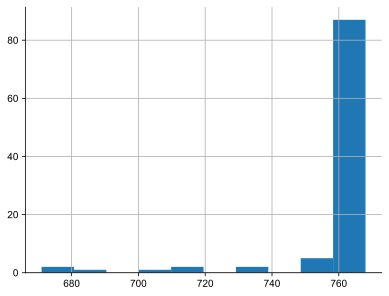

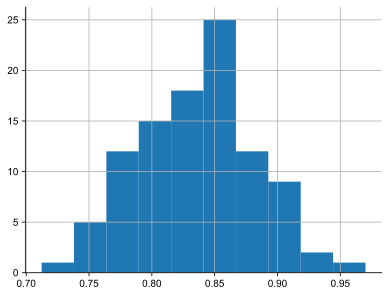

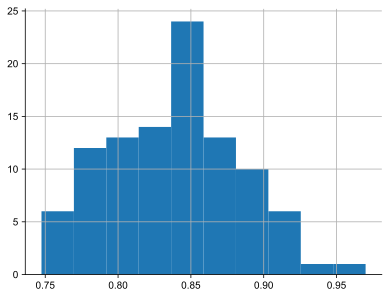

In [10]:
#general stats on amount of data per subject and subject performance
#display(data.subject.value_counts())
datat.subject.value_counts().hist()
plt.show()
data.groupby('subject').correct.mean().hist()
plt.show()
datat.groupby('subject').correct.mean().hist()
plt.show()

In [11]:
#define rho conditions for getting fits/samples later

rho_conds = datat.rho_cond.unique()
rho_conds_filestring = {r:str(r).replace('.','') for r in rho_conds}
rho_signs = np.array([-1.0,0.0,1.0])

In [12]:
#output full data for other processing
if False:
    datat_out = datat.join(subj_SNR[['uSNR']],on=['subject','SNR'])
    assert datat_out.loc[:,'trial':'SNR'].equals(datat), "Problem with joining uSNR to data!"
    assert not datat_out['uSNR'].isna().any(), "Problem with joining uSNR to data: missing uSNR values!"
    datat_out.to_csv(path.join(data_dir,'all_parsed_data_%s.csv' % date.today()),index=False)

### plot basic behavioral fig

In [13]:
datat_psycho_ave = \
    datat[['subject','rho','SNR','mu','response']].groupby(['subject','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_psycho_ave.groupby('rho').head())

datat_chrono_ave = \
    datat[['subject','rho','SNR','mu','correct','RT']].groupby(['subject','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave.groupby('rho').head())

response                    
                                                  mean       std       sem
subject                  rho  SNR   mu                                    
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350  0.109375  0.314576  0.039322
                              -0.12 -0.01340  0.359375  0.483610  0.060451
                               0.12  0.01340  0.703125  0.460493  0.057562
                               0.75  0.03350  0.984375  0.125000  0.015625
                          0.0 -0.75 -0.04325  0.109375  0.314576  0.039322
                              -0.12 -0.01730  0.406250  0.495015  0.061877
                               0.12  0.01730  0.906250  0.293785  0.036723
                               0.75  0.04325  0.968750  0.175368  0.021921
                          0.4 -0.75 -0.05118  0.093750  0.293785  0.036723
                              -0.12 -0.02047  0.281250  0.453163  0.056645
                               0.12  0.02047  0.843750  0.365963  0.045745
                               0.75  0.05118  0.953125  0.213042  0.026630
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897  0.066667  0.251549  0.032475
                              -0.12 -0.00759  0.403226  0.494550  0.062808
                               0.12  0.00759  0.796875  0.405505  0.050688
                               0.72  0.01897  0.951613  0.216335  0.027475
                          0.0 -0.72 -0.04241  0.015625  0.125000  0.015625
                          0.8 -0.72 -0.05690  0.063492  0.245805  0.030968
                              -0.12 -0.02276  0.317460  0.469227  0.059117
                               0.12  0.02276  0.777778  0.419079  0.052799
                               0.72  0.05690  0.967742  0.178127  0.022622
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987  0.078125  0.270490  0.033811
                              -0.14 -0.01195  0.406250  0.495015  0.061877
                               0.14  0.01195  0.796875  0.405505  0.050688
                               0.89  0.02987  0.953125  0.213042  0.026630
                          0.6 -0.89 -0.05974  0.046875  0.213042  0.026630
                              -0.14 -0.02390  0.296875  0.460493  0.057562
                               0.14  0.02390  0.812500  0.393398  0.049175
                               0.89  0.05974  1.000000  0.000000  0.000000
5b3455bf532e3d00018e6e8b -0.8 -0.66 -0.01819  0.187500  0.393398  0.049175
                          0.8 -0.66 -0.05458  0.140625  0.350382  0.043798
5b5ca33f295c4b0001c294d0 -0.4 -0.81 -0.03477  0.000000  0.000000  0.000000
                          0.4 -0.81 -0.05311  0.015625  0.125000  0.015625
5b8c8e7d0c740e00019d55c3 -0.6 -0.86 -0.02938  0.062500  0.243975  0.030497
                          0.6 -0.86 -0.05877  0.031250  0.175368  0.021921
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015  0.062500  0.243975  0.030497
                              -0.13 -0.01606  0.281250  0.453163  0.056645
                               0.13  0.01606  0.734375  0.445157  0.055645
                               0.81  0.04015  0.984375  0.125000  0.015625
                          0.2 -0.81 -0.04917  0.046875  0.213042  0.026630
                              -0.13 -0.01967  0.187500  0.393398  0.049175
                               0.13  0.01967  0.734375  0.445157  0.055645
                               0.81  0.04917  0.968750  0.175368  0.021921
5d645bf6912c630018e269e3 -0.2 -1.04 -0.04552  0.171875  0.380254  0.047532
                          0.2 -1.04 -0.05575  0.171875  0.380254  0.047532

RT            \
                                                          mean       std   
subject                  rho  SNR   mu       correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      3.605714  1.856701   
                                             1.0      2.734781  0.882488   
                              -0.12 -0.01340 0.0      3.086874  1.135117   
                                             1.0      2.946388  1.004948   
                               0.12  0.01340 0.0      2.496626  0.843780   
                          0.0 -0.75 -0.04325 0.0      2.002286  0.751804   
                                             1.0      2.570647  0.907455   
                              -0.12 -0.01730 0.0      2.922254  1.086153   
                                             1.0      2.827755  1.218041   
                               0.12  0.01730 0.0      3.486450  1.120658   
                          0.4 -0.75 -0.05118 0.0      2.415867  1.289492   
                                             1.0      2.459212  0.947419   
                              -0.12 -0.02047 0.0      2.560089  1.108950   
                                             1.0      2.841450  1.080723   
                               0.12  0.02047 0.0      2.639440  0.818084   
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897 0.0      3.699500  1.988548   
                                             1.0      2.911679  1.699150   
                              -0.12 -0.00759 0.0      3.611480  1.743437   
                                             1.0      3.066297  1.279710   
                               0.12  0.00759 0.0      3.047923  0.833213   
                          0.8 -0.72 -0.05690 0.0      2.891750  1.169060   
                                             1.0      2.568153  1.000523   
                              -0.12 -0.02276 0.0      3.183400  1.449378   
                                             1.0      2.955535  1.149211   
                               0.12  0.02276 0.0      2.760357  1.794017   
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987 0.0      4.957400  2.912065   
                                             1.0      2.915008  1.176968   
                              -0.14 -0.01195 0.0      3.624435  2.355111   
                                             1.0      3.045018  1.676974   
                               0.14  0.01195 0.0      2.876669  1.571359   
                          0.6 -0.89 -0.05974 0.0      1.477633  0.249984   
                                             1.0      2.724497  1.460335   
                              -0.14 -0.02390 0.0      3.673842  2.460267   
                                             1.0      3.078538  2.174258   
                               0.14  0.02390 0.0      3.566825  2.188608   
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015 0.0      2.806550  1.100412   
                                             1.0      1.994917  0.671982   
                              -0.13 -0.01606 0.0      2.689339  0.793360   
                                             1.0      2.041659  0.551630   
                               0.13  0.01606 0.0      2.491012  0.884248   
                          0.2 -0.81 -0.04917 0.0      2.370533  0.696690   
                                             1.0      1.967684  0.674544   
                              -0.13 -0.01967 0.0      2.643167  0.740102   
                                             1.0      2.101046  0.610086   
                               0.13  0.01967 0.0      2.224988  0.505722   

                                                                
                                                           sem  
subject                  rho  SNR   mu       correct            
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      0.701767  
                                             1.0      0.116888  
                              -0.12 -0.01340 0.0      0.236688  
                     

In [14]:
#now create RT normed by rho==0.0 RT (averaged across all data per subj, separate for correct/error)

datat_r0_SNR_chrono_ave = \
    datat.loc[datat.rho==0.0,['subject','correct','SNR','RT']].groupby(['subject','correct','SNR']).agg(['mean'])
display(datat_r0_SNR_chrono_ave.head())
datat_r0_chrono_ave = datat_r0_SNR_chrono_ave.xs('mean',axis=1,level=1).groupby(['subject','correct']).agg(['mean'])
display(datat_r0_chrono_ave.head())

RT_norm = datat_chrono_ave[[('RT','mean')]] - datat_r0_chrono_ave[[('RT','mean')]]
datat_chrono_ave= datat_chrono_ave.join(RT_norm,rsuffix='_norm0')
display(datat_chrono_ave.head())

RT
                                            mean
subject                  correct SNR            
575f387c91f8b40006c332e1 0.0     -0.75  2.002286
                                 -0.12  2.922254
                                  0.12  3.486450
                                  0.75  2.731550
                         1.0     -0.75  2.570647

RT
                                      mean
subject                  correct          
575f387c91f8b40006c332e1 0.0      2.785635
                         1.0      2.650590
58f82417edbd82000169bce8 0.0      2.449071
                         1.0      2.791224
5b232f6838fc0c000131438c 0.0      3.230544

RT            \
                                                         mean       std   
subject                  rho  SNR   mu      correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      3.605714  1.856701   
                                            1.0      2.734781  0.882488   
                              -0.12 -0.0134 0.0      3.086874  1.135117   
                                            1.0      2.946388  1.004948   
                               0.12  0.0134 0.0      2.496626  0.843780   

                                                               RT_norm0  
                                                          sem      mean  
subject                  rho  SNR   mu      correct                      
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      0.701767  0.820079  
                                            1.0      0.116888  0.084191  
                              -0.12 -0.0134 0.0      0.236688  0.301239  
                                            1.0      0.156947  0.295798  
                               0.12  0.0134 0.0      0.193576 -0.289009

In [15]:
datat_psycho_ave_all = \
    datat_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR']).agg(['mean','std','sem'])
display(datat_psycho_ave_all)

datat_chrono_ave_all = \
    datat_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave_all)

response                     rSNR          
                  mean       std       sem mean  std  sem
rho  uSNR                                                
-0.8 -0.9239  0.095098  0.061610  0.012322  1.0  0.0  0.0
     -0.1480  0.289612  0.111452  0.022290  2.0  0.0  0.0
      0.1480  0.711479  0.089335  0.017867  3.0  0.0  0.0
      0.9239  0.924907  0.051747  0.010349  4.0  0.0  0.0
-0.6 -0.9239  0.081639  0.052622  0.010524  1.0  0.0  0.0
     -0.1480  0.283473  0.090698  0.018140  2.0  0.0  0.0
      0.1480  0.752392  0.071163  0.014233  3.0  0.0  0.0
      0.9239  0.916485  0.047024  0.009405  4.0  0.0  0.0
-0.4 -0.9239  0.053611  0.047643  0.009529  1.0  0.0  0.0
     -0.1480  0.227794  0.122965  0.024593  2.0  0.0  0.0
      0.1480  0.769287  0.090160  0.018032  3.0  0.0  0.0
      0.9239  0.941389  0.043959  0.008792  4.0  0.0  0.0
-0.2 -0.9239  0.085252  0.050260  0.010052  1.0  0.0  0.0
     -0.1480  0.283214  0.081900  0.016380  2.0  0.0  0.0
      0.1480  0.739003  0.074175  0.014835  3.0  0.0  0.0
      0.9239  0.917261  0.059933  0.011987  4.0  0.0  0.0
 0.0 -0.9239  0.075545  0.056731  0.005673  1.0  0.0  0.0
     -0.1480  0.267933  0.096548  0.009655  2.0  0.0  0.0
      0.1480  0.772412  0.080849  0.008085  3.0  0.0  0.0
      0.9239  0.932959  0.053089  0.005309  4.0  0.0  0.0
 0.2 -0.9239  0.085672  0.057869  0.011574  1.0  0.0  0.0
     -0.1480  0.277182  0.071597  0.014319  2.0  0.0  0.0
      0.1480  0.759754  0.074592  0.014918  3.0  0.0  0.0
      0.9239  0.919718  0.039722  0.007944  4.0  0.0  0.0
 0.4 -0.9239  0.066985  0.050029  0.010006  1.0  0.0  0.0
     -0.1480  0.232314  0.107188  0.021438  2.0  0.0  0.0
      0.1480  0.773078  0.093741  0.018748  3.0  0.0  0.0
      0.9239  0.950303  0.038987  0.007797  4.0  0.0  0.0
 0.6 -0.9239  0.065321  0.041583  0.008317  1.0  0.0  0.0
     -0.1480  0.261880  0.091798  0.018360  2.0  0.0  0.0
      0.1480  0.758433  0.077942  0.015588  3.0  0.0  0.0
      0.9239  0.947710  0.043345  0.008669  4.0  0.0  0.0
 0.8 -0.9239  0.060619  0.041266  0.008253  1.0  0.0  0.0
     -0.1480  0.257721  0.087919  0.017584  2.0  0.0  0.0
      0.1480  0.785974  0.073793  0.014759  3.0  0.0  0.0
      0.9239  0.951316  0.037494  0.007499  4.0  0.0  0.0

RT                      RT_norm0            \
                          mean       std       sem      mean       std   
rho  uSNR    correct                                                     
-0.8 -0.9239 0.0      3.255500  1.792148  0.358430  0.805786  1.504709   
             1.0      2.903680  0.843171  0.168634  0.470057  0.369767   
     -0.1480 0.0      3.839407  1.417452  0.283490  1.389693  0.988517   
             1.0      3.445038  1.091729  0.218346  1.011416  0.544051   
      0.1480 0.0      3.371822  1.332527  0.266505  0.922108  0.918590   
...                        ...       ...       ...       ...       ...   
 0.8 -0.1480 1.0      2.481942  0.802311  0.160462  0.048319  0.287145   
      0.1480 0.0      2.530168  1.059625  0.211925  0.080455  0.687738   
             1.0      2.428839  0.887333  0.177467 -0.004784  0.279658   
      0.9239 0.0      2.120885  1.752033  0.365324 -0.231899  1.684788   
             1.0      1.915635  0.510659  0.102132 -0.517987  0.338379   

                               rSNR            
                           sem mean  std  sem  
rho  uSNR    correct                           
-0.8 -0.9239 0.0      0.300942  1.0  0.0  0.0  
             1.0      0.073953  1.0  0.0  0.0  
     -0.1480 0.0      0.197703  2.0  0.0  0.0  
             1.0      0.108810  2.0  0.0  0.0  
      0.1480 0.0      0.183718  3.0  0.0  0.0  
...                        ...  ...  ...  ...  
 0.8 -0.1480 1.0      0.057429  2.0  0.0  0.0  
      0.1480 0.0      0.137548  3.0  0.0  0.0  
             1.0      0.055932  3.0  0.0  0.0  
      0.9239 0.0      0.351303  4.0  0.0  0.0  
             1.0      0.067676  4.0  0.0  0.0  

[72 rows x 9 columns]

In [16]:
cmap_stacked = mpl.colormaps['RdBu'](np.linspace(0,1,9))
cmap_stacked[4] = [0.5,0.5,0.5,1.0]
rhos = datat_psycho_ave_all.index.get_level_values('rho').sort_values().unique().to_numpy()

r_colors_stacked = dict(zip(rhos, cmap_stacked))

### paper plot

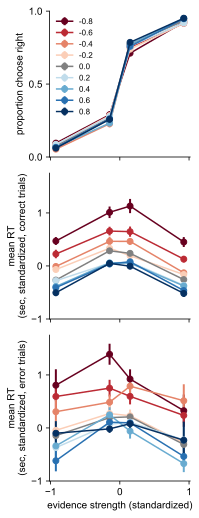

In [17]:
#first plot basic behavioral fits stacked, RT normalized version, vertical version
cm = 1/2.54  # centimeters in inches
plot_err = True

fig,ax = plt.subplots(nrows=2+plot_err,ncols=1)
for (r,dd),(rr,ddc) in zip(datat_psycho_ave_all.groupby('rho'),datat_chrono_ave_all.groupby('rho')):
        #plot psycho
        assert r==rr
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)


        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index,chrono_corr['RT_norm0']['mean'],chrono_corr['RT_norm0']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
        
        if plot_err:
            chrono_err = ddc.xs(0.0,level='correct')
        
            ax[2].errorbar(chrono_err.index,chrono_err['RT_norm0']['mean'],chrono_err['RT_norm0']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
            
        
#set_size(plt_size[0],plt_size[1],ax[0])
ax[0].legend(frameon=False,loc='upper left')
#ax[0].set_xlabel('SNR (normalized)')
ax[0].set_xticks((-1.0,0.0,1.0))
ax[0].set_xticklabels(())
ax[0].set_yticks((0,0.5,1))
ax[0].set_ylim((0,1))
ax[0].set_ylabel('proportion choose right')

#set_size(plt_size[0],plt_size[1],ax[1])
if not plot_err:
    ax[1].set_xlabel('evidence strength (standardized)')
ax[1].set_xticks((-1.0,0.0,1.0))
ax[1].set_xticklabels(())
ax[1].set_ylim((-1,1.75))
ax[1].locator_params(nbins=3, axis='y')
ax[1].set_ylabel('mean RT\n(sec, standardized, correct trials)');

if plot_err:
    #set_size(plt_size[0],plt_size[1],ax[2])
    ax[2].set_xlabel('evidence strength (standardized)')
    ax[2].set_xticks((-1.0,0.0,1.0))
    ax[2].set_ylim((-1,1.75))
    ax[2].locator_params(nbins=3, axis='y')
    ax[2].set_ylabel('mean RT\n(sec, standardized, error trials)');
    

fig.set_figwidth(7.25*cm)
fig.set_figheight(18.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig3_all_%s.pdf' % date.today()))

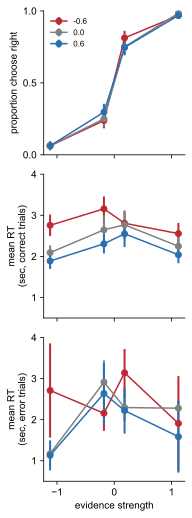

In [18]:
#plot example subject, vertical
ex_subj = '615b4d67bd21e66571f5581b'


#first plot basic behavioral fits stacked, RT normalized version
cm = 1/2.54  # centimeters in inches
plot_err = True

fig,ax = plt.subplots(nrows=2+plot_err,ncols=1)
for (r,dd),(rr,ddc) in zip(datat_psycho_ave.loc[ex_subj].groupby('rho'),
                           datat_chrono_ave.loc[ex_subj].groupby('rho')):
        #plot psycho
        assert r==rr
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index.get_level_values('SNR'),dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)


        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index.get_level_values('SNR'),chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
        
        if plot_err:
            chrono_err = ddc.xs(0.0,level='correct')
        
            ax[2].errorbar(chrono_err.index.get_level_values('SNR'),chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
            
        
ax[0].legend(frameon=False)
#ax[0].set_xlabel('SNR')
ax[0].set_xticks((-1.0,0.0,1.0))
ax[0].set_xticklabels(())
ax[0].set_yticks((0,0.5,1))
ax[0].set_ylim((0,1))
ax[0].set_ylabel('proportion choose right')

if not plot_err:
    ax[1].set_xlabel('evidence strength')
ax[1].set_xticks((-1.0,0.0,1.0))
ax[1].set_xticklabels(())
ax[1].set_ylim((0.5,4))
ax[1].locator_params(nbins=6, axis='y')
ax[1].set_ylabel('mean RT\n(sec, correct trials)');

if plot_err:
    ax[2].set_xlabel('evidence strength')
    ax[2].set_xticks((-1.0,0.0,1.0))
    ax[2].set_ylim((0.5,4))
    ax[2].locator_params(nbins=6, axis='y')
    ax[2].set_ylabel('mean RT\n(sec, error trials)');
    

fig.set_figwidth(7.0*cm)
fig.set_figheight(18.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig3_exsubj_%s.pdf' % date.today()))

# schematics 
Schematics for figures.

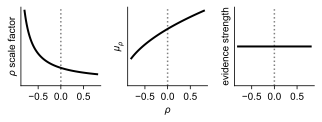

In [19]:
#schematic for showing how mean changes while rho stays fixed

mu_0 = 0.5
corr_smooth = np.linspace(-0.8,0.8,100)
mu_corr = mu_0*np.sqrt(1+corr_smooth)
rho_corr = 1/(1+corr_smooth)
SNR_basic = (mu_corr**2)*rho_corr #ignores some scale factor due to sd, etc

fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].axhline(0,linestyle=':',color='k',alpha=0.0)
ax[0].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[0].plot(corr_smooth,rho_corr,color='k',linewidth=2)
ax[0].set_yticks([])
ax[0].set_ylabel(r'$\rho$ scale factor')


ax[1].axhline(0,linestyle=':',color='k',alpha=0.0)
ax[1].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[1].plot(corr_smooth,mu_corr,color='k',linewidth=2)
ax[1].set_yticks([])
ax[1].set_ylabel(r'$\mu_{\rho}$')
ax[1].set_xlabel(r'$\rho$')


ax[2].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[2].plot(corr_smooth,SNR_basic,color='k',linewidth=2)
ax[2].set_yticks([])
ax[2].set_ylabel('evidence strength')


fig.set_figheight(4.6*cm)
fig.set_figwidth(11.75*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig2_scaling_%s.pdf' % date.today()))

[0.06070308 0.09598    0.12140616]
[0.17888544 0.28284271 0.35777088]


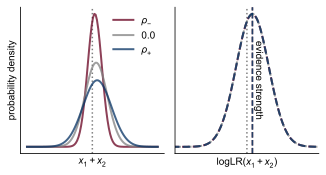

In [20]:
#analytic distributions for generative distributions and LLR, using sum distribution 
cm = 1/2.54

cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.5,0.5,0.5,1.0),cmap[-1]]))

gen_spec=pd.Series({'mu':0.04799,'sd':0.2})
r_analytic = np.array([-0.6,0.0,0.6])
mu_analytic = gen_spec.mu*np.sqrt(1+r_analytic)

mu_sumdist = 2*mu_analytic #mean for sum distribution
sd_sumdist = np.sqrt(2*(1+r_analytic))*gen_spec.sd #sd for sum distribution version of generative dist
print(mu_sumdist)
print(sd_sumdist)

xrange = np.linspace(st.norm.ppf(0.05),
                st.norm.ppf(1.0-0.05), 100)
   
    
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].axvline(0,linestyle=':',color='k',alpha=0.5)
schem_lines = []
for m,s,r in zip(mu_sumdist,sd_sumdist,r_analytic):
    liner, = ax[0].plot(xrange,st.norm.pdf(xrange,loc=m,scale=s),linewidth=2,alpha=0.75,color=r_colors[np.sign(r)])
    schem_lines.append(liner)

ax[0].set_yticks([])
ax[0].set_ylabel('probability density')
ax[0].set_xticks([])
ax[0].set_xlabel(r'$x_1+x_2$');
ax[0].legend(handles=schem_lines,labels=(r'$\rho_{\minus}$','0.0',r'$\rho_{\plus}$'),
             frameon=False,fontsize=10)

ax[1].axvline(0,linestyle=':',color='k',alpha=0.5)
for m,s,r in zip(mu_sumdist,sd_sumdist,r_analytic):
    LLRi_scale = m/(s**2/2)
    LLR_sampi = LLRi_scale*st.norm.rvs(loc=m,scale=s,size=100000)
    ax[1].plot(xrange*LLRi_scale,st.norm.pdf(xrange*LLRi_scale,loc=m*LLRi_scale,scale=s*LLRi_scale),
               color=r_colors[np.sign(r)],alpha=0.75,linewidth=2,linestyle='--')
    snr_line=ax[1].axvline(LLRi_scale*m,linestyle='--',color=r_colors[np.sign(r)],alpha=0.75,linewidth=1.5)
    

ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(r'logLR($x_1+x_2$)');
ax[1].set_xlim([-3,3])

ax[1].annotate('evidence strength', (0.5, 0.5), xytext=(1.5,0), xycoords=snr_line, 
               va='center',rotation=-90, textcoords="offset points")


fig.set_figheight(6.5*cm)
fig.set_figwidth(11.75*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig2_pdf_%s.pdf' % date.today()))

# Fits

## Load/assess joint (shared) fits

Here we will load and analyze all models that fit all correlation conditions in a correlation group jointly, where differences between the models are in whether parameters are shared between or vary across the correlation conditions.

In [21]:
shared_mods = ['rsharedCLT','bound_rscaleCLT_sk','bound_sharedCLT_vk','bound_rscaleCLT_vrh','bound_rscaleCLT_vr2','bound_rscaleCLT_vk']

In [22]:
shared_samps = {}
for rc in rho_conds:
    shared_samps[rc],_ = \
        gdw.load_data(datat.loc[(datat.rho_cond==rc)].copy(),
                      rt="RT",conds=['rho','mu'],verbose=False,debug=False)
        
#quick and dirty gut check
assert np.all(np.array([len(x) for x in shared_samps.values()])==25), "Incorrect number of subjects per corr!"

In [23]:
#get fit for all models
shared_fits = {}
for rc in rho_conds:
    shared_fits[rc] = {}
    for m in shared_mods:
        print('%s - %s' % (rc,m))
        shared_fits[rc][m] = \
            gdw.load_models(path.join(fit_dir,'%s_*_r%s_*_202?-??-??' % (m,rho_conds_filestring[rc])),
                            verbose=True)
        assert len(shared_fits[rc][m])==len(shared_samps[rc].keys()), "Incorrect number of models loaded!"
        shared_fits[rc][m] = {f.subject:f for f in shared_fits[rc][m]}
        
print(np.array([len(x) for x in shared_fits.values()]))
print(np.array([len(y) for x in shared_fits.values() for y in x.values()]))

0.2 - rsharedCLT
loaded models:
./data/fits/rsharedCLT_May10_r02_5f30ee4c383a0d56521f69c7_2023-06-21
./data/fits/rsharedCLT_May10_r02_613a8ef513f5e9934f6f6fb3_2023-06-21
./data/fits/rsharedCLT_May10_r02_613433e6d6d82dbdad53e847_2023-06-21
./data/fits/rsharedCLT_May10_r02_60fead47231209607137f36e_2023-06-21
./data/fits/rsharedCLT_May10_r02_60fe1c233dd0ee9020efca7e_2023-06-21
./data/fits/rsharedCLT_May10_r02_5f3ee36d0306de1a411882a5_2023-06-21
./data/fits/rsharedCLT_May10_r02_5f74fa0614255d15319ee076_2023-06-21
./data/fits/rsharedCLT_May10_r02_6154b3a7e4bc93e1ce93c6bc_2023-06-21
./data/fits/rsharedCLT_May10_r02_5ef37588bfe86a0ca12ba515_2023-06-21
./data/fits/rsharedCLT_May10_r02_5f2de3a7b874e712ac7bc516_2023-06-21
./data/fits/rsharedCLT_May10_r02_5e705a1be6c65a62c56a3143_2023-06-21
./data/fits/rsharedCLT_May10_r02_61267b828ead584bcf092e35_2023-06-21
./data/fits/rsharedCLT_May10_r02_616f469494656434f5b4ebc6_2023-06-21
./data/fits/rsharedCLT_May10_r02_600b9a216e864a1f9316c1dd_2023-06-21
./

In [24]:
#let's actually get params first so we can check on boundary issues before going to the trouble of solving

params_shared = []
for rc,fdict in shared_fits.items():
    print(rc)
    for m,fits in fdict.items():
        print(m)
        #print(fits)
        if len(fits) > 0:
            parami = ddm_corr.get_all_params(fits)
            parami['rho_cond'] = rc
            parami['model'] = m
            params_shared.append(parami)
    
params_shared = pd.concat(params_shared)
params_shared.set_index(['rho_cond','model','subject'],inplace=True,append=True)
params_shared = params_shared.reorder_levels(['rho_cond','model','subject','param']).sort_index()

0.2
rsharedCLT
                  value hit_boundary                   subject
param                                                         
driftSNR0     12.538418        False  5f30ee4c383a0d56521f69c7
B0             1.536982        False  5f30ee4c383a0d56521f69c7
t              0.000000         True  5f30ee4c383a0d56521f69c7
nondectime     0.242746        False  5f30ee4c383a0d56521f69c7
umixturecoef   0.021150        False  5f30ee4c383a0d56521f69c7
                 value hit_boundary                   subject
param                                                        
t             0.000000         True  5f30ee4c383a0d56521f69c7
umixturecoef  0.001000         True  613a8ef513f5e9934f6f6fb3
umixturecoef  0.002081         True  613433e6d6d82dbdad53e847
t             0.037866         True  5f74fa0614255d15319ee076
t             0.036171         True  61267b828ead584bcf092e35
umixturecoef  0.001000         True  61267b828ead584bcf092e35
t             0.025179         True  616f4694946

In [25]:
params_shared

value  \
rho_cond model              subject                  param                     
0.2      bound_rscaleCLT_sk 5bd781291fd7c80001bb1fad B0             2.003177   
                                                     Rn            -0.176253   
                                                     Rp             0.160580   
                                                     driftSNR0     25.303063   
                                                     nondectime     0.687041   
...                                                                      ...   
0.8      rsharedCLT         614fc66c9094c0a205c09a69 B0             2.557039   
                                                     driftSNR0     18.014921   
                                                     nondectime     0.583738   
                                                     t              0.460736   
                                                     umixturecoef   0.126063   

                                                                  hit_boundary  
rho_cond model              subject                  param                      
0.2      bound_rscaleCLT_sk 5bd781291fd7c80001bb1fad B0                  False  
                                                     Rn                  False  
                                                     Rp                  False  
                                                     driftSNR0           False  
                                                     nondectime          False  
...                                                                        ...  
0.8      rsharedCLT         614fc66c9094c0a205c09a69 B0                  False  
                                                     driftSNR0           False  
                                                     nondectime          False  
                                                     t                   False  
                                                     umixturecoef        False  

[4400 rows x 2 columns]

In [26]:
#some sanity checks
assert np.all(params_shared.xs('t',level='param').groupby(['model','rho_cond']).size().to_numpy()==25), \
    "Wrong number of subjects per model in params"
assert len(params_shared.xs('t',level='param').groupby(['model','rho_cond']).size())==len(rho_conds)*len(shared_mods), \
    "Wrong number of model/rho cond combinations in params"

#first pass check for any problematic fits re: param bounds
display(params_shared.loc[params_shared.hit_boundary].groupby('param').hit_boundary.value_counts())
display(params_shared.loc[params_shared.hit_boundary].groupby('param').min())
display(params_shared.loc[params_shared.hit_boundary].groupby('param').max())

param         hit_boundary
Rp            True              1
nondectime    True             17
t             True            217
umixturecoef  True            151
Name: hit_boundary, dtype: int64

,value,hit_boundary
param,,
Rp,0.890464,True
nondectime,0.001250,True
t,0.000000,True
umixturecoef,0.001000,True


,value,hit_boundary
param,,
Rp,0.890464,True
nondectime,0.029559,True
t,0.058188,True
umixturecoef,0.003970,True


In [27]:
#predictions under same time as RT cutoff
do_sols = False
forced=False
sim_tdur = 15

if forced:
    forceflag = ''
    renorm = False
else:
    forceflag = '_unforced'
    renorm = True
    
if sim_tdur is not None:
    tdur_flag = '_tdur%d' % sim_tdur
else:
    tdur_flag = ''

if do_sols:
    shared_soldf = {k:{} for k in shared_mods}
    for (sk,sv),(mk,mv) in zip(shared_samps.items(),shared_fits.items()):
        assert sk==mk
        print(sk)
        #print(sv)
        #shared_soldf[sk] = {}
        for mvn,mvi in mv.items():
            print(mvn)
            mvi = copy.deepcopy(mvi)
            if sim_tdur is not None:
                for mmm in mvi.values():
                    mmm.T_dur = sim_tdur
            soldf = ddm_corr.get_all_sols(sv,mvi,forced=forced,renorm=renorm)
            #soldf = {}
            soldf['rho_cond'] = sk
            soldf['model'] = mvn
            #print(soldf)

            shared_soldf[mvn][sk] = soldf
            
    with open(path.join(fit_dir,'shared_sols%s%s_%s' % (forceflag,tdur_flag,date.today())),'wb') as f:
        pickle.dump(shared_soldf,f)
else:
    with open(path.join(fit_dir,'shared_sols_unforced_tdur15_2025-01-15'),'rb') as f:
        shared_soldf = pickle.load(f)

#These are probably overkill and some guaranteed to pass, but better safe than sorry...   
assert len(shared_soldf)==len(shared_mods), "Not all model sols present!"
assert np.array_equal(list(shared_soldf.keys()),shared_mods), "Not all model sols present!"
assert np.all(np.array([len(f.keys()) for f in shared_soldf.values()])==len(rho_conds)), "Not all rho_conds present for all model types!"
assert np.all(np.array([len(y.subject.unique()) for x in shared_soldf.values() for y in x.values()])==25), 'Incorrect number of subjects in solutions'
assert np.all(np.array([y.groupby('subject').size().unique() for x in shared_soldf.values() for y in x.values()])==12), 'Incorrect number of solutions per subject'

shared_soldf = {k:pd.concat(v,ignore_index=True).set_index(['subject','rho_cond']) for k,v in shared_soldf.items()}
shared_soldf

{'rsharedCLT':                                    rho       mu  mean_corr  mean_err  \
 subject                  rho_cond                                      
 5f30ee4c383a0d56521f69c7 0.2       0.0 -0.02818   0.743460  0.256540   
                          0.2       0.2 -0.03088   0.725543  0.274457   
                          0.2       0.2 -0.07719   0.914588  0.085412   
                          0.2      -0.2  0.06302   0.945074  0.054926   
                          0.2      -0.2 -0.02521   0.766179  0.233821   
 ...                                ...      ...        ...       ...   
 6010b797bbe6be440425665c 0.8       0.0  0.02092   0.750820  0.249180   
                          0.8       0.0 -0.05229   0.915721  0.084279   
                          0.8       0.0 -0.02092   0.750820  0.249180   
                          0.8      -0.8 -0.02339   0.941302  0.058698   
                          0.8       0.8  0.02806   0.712468  0.287532   
 
                                   

In [28]:
for df in shared_soldf.values():
    assert (df.groupby('subject').count()==12).all().all(), 'Incorrect number of conditions detected in solution!'

In [29]:
#combine predictions w/ data
datat_mshared_dict = {m:ddm_corr.data_pred_merge(datat,sols,on=['subject','rho_cond','rho','mu']) 
                 for m,sols in shared_soldf.items()}

   trial                   subject  rho       mu      RT  response  correct  \
0      1  5f3ee36d0306de1a411882a5  0.2  0.02069  1.6825       1.0      1.0   
1     18  5f3ee36d0306de1a411882a5  0.2  0.02069  2.9287       1.0      1.0   
2     36  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6330       0.0      0.0   
3     40  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6890       1.0      1.0   
4     59  5f3ee36d0306de1a411882a5  0.2  0.02069  1.7222       0.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0  0.142692   0.356901       0.2  0.14   0.709821  0.290179      2.441543   
1  0.142692   0.356901       0.2  0.14   0.709821  0.290179      2.441543   
2  0.142692   0.356901       0.2  0.14   0.709821  0.290179      2.441543   
3  0.142692   0.356901       0.2  0.14   0.709821  0.290179      2.441543   
4  0.142692   0.356901       0.2  0.14   0.709821  0.290179      2.441543   

   mean_RT_err       model  pred_response  
0     2.625192  rs

In [30]:
#bind all predictions into one df...awk...

mod_cols = ['pred_response','mean_RT_corr','mean_RT_err']


datat_mshared = datat_mshared_dict[shared_mods[0]].drop(['mean_corr','mean_err','model'],axis=1).merge(datat_mshared_dict[shared_mods[1]][['rho_cond','subject','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                         on=['rho_cond','subject','trial'],
                                                        suffixes=('_'+x for x in shared_mods[0:2]),
                                                          validate='1:1')
for m in shared_mods[2:]:
    datat_mshared = datat_mshared.merge(datat_mshared_dict[m][['rho_cond','subject','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                         on=['rho_cond','subject','trial'],
                                                          validate='1:1')
    datat_mshared.rename(dict(zip(mod_cols,[x + '_' + m for x in mod_cols])),axis=1,inplace=True)
    
datat_mshared.head()

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,mean_RT_err_bound_sharedCLT_vk,pred_response_bound_rscaleCLT_vrh,mean_RT_corr_bound_rscaleCLT_vrh,mean_RT_err_bound_rscaleCLT_vrh,pred_response_bound_rscaleCLT_vr2,mean_RT_corr_bound_rscaleCLT_vr2,mean_RT_err_bound_rscaleCLT_vr2,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,2.636198,0.742174,2.676869,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,2.636198,0.742174,2.676869,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,2.636198,0.742174,2.676869,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,2.636198,0.742174,2.676869,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,2.636198,0.742174,2.676869,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631


In [31]:
#save out for learning effect analysis (Josh)
if False:
    mshared_out_cols = ['trial', 'subject', 'rho', 'mu', 'RT', 'response', 'correct', 'SNRraw',
       'threshold', 'rho_cond', 'SNR', 
       'pred_response_bound_rscaleCLT_sk', 'mean_RT_corr_bound_rscaleCLT_sk',
       'mean_RT_err_bound_rscaleCLT_sk', 'pred_response_bound_rscaleCLT_vrh', 'mean_RT_corr_bound_rscaleCLT_vrh',
       'mean_RT_err_bound_rscaleCLT_vrh']
    datat_mshared_out = datat_mshared[mshared_out_cols].copy()
    
    #so as not to cause confusion, nan out RTs from opposite correctness
    datat_mshared_out.loc[datat_mshared_out.correct==0,'mean_RT_corr_bound_rscaleCLT_sk'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==0,'mean_RT_corr_bound_rscaleCLT_vrh'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==1,'mean_RT_err_bound_rscaleCLT_sk'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==1,'mean_RT_err_bound_rscaleCLT_vrh'] = np.nan
    
    #assign _vrh as best fitting model for all conditions
    datat_mshared_out['mean_RT_corr_best'] = datat_mshared_out['mean_RT_corr_bound_rscaleCLT_vrh']
    assert datat_mshared_out['mean_RT_corr_bound_rscaleCLT_vrh'].equals(\
        datat_mshared_out['mean_RT_corr_best'])
    
    datat_mshared_out['mean_RT_err_best'] = datat_mshared_out['mean_RT_err_bound_rscaleCLT_vrh']
    assert datat_mshared_out['mean_RT_err_bound_rscaleCLT_vrh'].equals(\
        datat_mshared_out['mean_RT_err_best'])
       
    datat_mshared_out['pred_response_best'] = datat_mshared_out['pred_response_bound_rscaleCLT_vrh']
    assert datat_mshared_out['pred_response_bound_rscaleCLT_vrh'].equals(\
        datat_mshared_out['pred_response_best'])
    
    
    display(datat_mshared_out.head())
    
    datat_mshared_out.to_csv(path.join(data_dir,'data_best_model_%s.csv' % date.today()),index=False)

In [32]:
#compute columns for best-fitting model (based on fit stats). 
#Redundant w/ _out above but not adding in the nans

datat_mshared['mean_RT_corr_best'] = datat_mshared['mean_RT_corr_bound_rscaleCLT_vrh']
assert datat_mshared['mean_RT_corr_bound_rscaleCLT_vrh'].equals(\
    datat_mshared['mean_RT_corr_best'])

datat_mshared['mean_RT_err_best'] = datat_mshared['mean_RT_err_bound_rscaleCLT_vrh']
assert datat_mshared['mean_RT_err_bound_rscaleCLT_vrh'].equals(\
    datat_mshared['mean_RT_err_best'])

datat_mshared['pred_response_best'] = datat_mshared['pred_response_bound_rscaleCLT_vrh']
assert datat_mshared['pred_response_bound_rscaleCLT_vrh'].equals(\
    datat_mshared['pred_response_best'])

display(datat_mshared.head())

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,mean_RT_err_bound_rscaleCLT_vrh,pred_response_bound_rscaleCLT_vr2,mean_RT_corr_bound_rscaleCLT_vr2,mean_RT_err_bound_rscaleCLT_vr2,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk,mean_RT_corr_best,mean_RT_err_best,pred_response_best
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631,2.676869,2.91886,0.742174
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631,2.676869,2.91886,0.742174
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631,2.676869,2.91886,0.742174
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631,2.676869,2.91886,0.742174
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,2.91886,0.745434,2.742299,3.04484,0.739999,2.549352,2.780631,2.676869,2.91886,0.742174


In [33]:
mod_cols_resp = ['_'.join(x) for x in product(['pred_response'],shared_mods+['best'])]
mod_cols_RT = ['_'.join(x) for x in product(['mean_RT_corr','mean_RT_err'],shared_mods+['best'])]
mod_cols_suffix = ['_'+x for x in shared_mods]
mod_lines = [':','-',(0,(1,10)),(0,(5,10))]

datat_mshared_psycho_ave = \
    datat_mshared[['subject','rho_cond','rho','SNR','mu','response']+mod_cols_resp].groupby(['subject','rho_cond','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_mshared_psycho_ave.groupby('rho_cond').head())

datat_mshared_chrono_ave = \
    datat_mshared[['subject','rho_cond','rho','SNR','mu','correct','RT']+mod_cols_RT].groupby(['subject','rho_cond','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_mshared_chrono_ave.groupby('rho_cond').head())

response            \
                                                           mean       std   
subject                  rho_cond rho  SNR   mu                             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.109375  0.314576   
                                       -0.12 -0.01340  0.359375  0.483610   
                                        0.12  0.01340  0.703125  0.460493   
                                        0.75  0.03350  0.984375  0.125000   
                                   0.0 -0.75 -0.04325  0.109375  0.314576   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.066667  0.251549   
                                       -0.12 -0.00759  0.403226  0.494550   
                                        0.12  0.00759  0.796875  0.405505   
                                        0.72  0.01897  0.951613  0.216335   
                                   0.0 -0.72 -0.04241  0.015625  0.125000   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.078125  0.270490   
                                       -0.14 -0.01195  0.406250  0.495015   
                                        0.14  0.01195  0.796875  0.405505   
                                        0.89  0.02987  0.953125  0.213042   
                                   0.0 -0.89 -0.04723  0.234375  0.426956   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.062500  0.243975   
                                       -0.13 -0.01606  0.281250  0.453163   
                                        0.13  0.01606  0.734375  0.445157   
                                        0.81  0.04015  0.984375  0.125000   
                                   0.0 -0.81 -0.04489  0.031250  0.175368   

                                                                 \
                                                            sem   
subject                  rho_cond rho  SNR   mu                   
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.039322   
                                       -0.12 -0.01340  0.060451   
                                        0.12  0.01340  0.057562   
                                        0.75  0.03350  0.015625   
                                   0.0 -0.75 -0.04325  0.039322   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.032475   
                                       -0.12 -0.00759  0.062808   
                                        0.12  0.00759  0.050688   
                                        0.72  0.01897  0.027475   
                                   0.0 -0.72 -0.04241  0.015625   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.033811   
                                       -0.14 -0.01195  0.061877   
                                        0.14  0.01195  0.050688   
                                        0.89  0.02987  0.026630   
                                   0.0 -0.89 -0.04723  0.053370   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.030497   
                                       -0.13 -0.01606  0.056645   
                                        0.13  0.01606  0.055645   
                                        0.81  0.04015  0.015625   
                                   0.0 -0.81 -0.04489  0.021921   

                                                      pred_response_rsharedCLT  \
                                                                          mean   
subject                  rho_cond rho  SNR   mu                                  
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350                 0.064363   
                                       -0.12 -0.01340                 0.269649   
                                        0.12  0.01340                 0.730351   
                                        0.75  0.03350                 0.935637   
                                   0.0 -0.75 -0.04325                 0.083911   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897                 0.109577   
   

RT  \
                                                                   mean   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      3.605714   
                                                      1.0      2.734781   
                                       -0.12 -0.01340 0.0      3.086874   
                                                      1.0      2.946388   
                                        0.12  0.01340 0.0      2.496626   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      3.699500   
                                                      1.0      2.911679   
                                       -0.12 -0.00759 0.0      3.611480   
                                                      1.0      3.066297   
                                        0.12  0.00759 0.0      3.047923   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      4.957400   
                                                      1.0      2.915008   
                                       -0.14 -0.01195 0.0      3.624435   
                                                      1.0      3.045018   
                                        0.14  0.01195 0.0      2.876669   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      2.806550   
                                                      1.0      1.994917   
                                       -0.13 -0.01606 0.0      2.689339   
                                                      1.0      2.041659   
                                        0.13  0.01606 0.0      2.491012   

                                                                         \
                                                                    std   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.856701   
                                                      1.0      0.882488   
                                       -0.12 -0.01340 0.0      1.135117   
                                                      1.0      1.004948   
                                        0.12  0.01340 0.0      0.843780   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      1.988548   
                                                      1.0      1.699150   
                                       -0.12 -0.00759 0.0      1.743437   
                                                      1.0      1.279710   
                                        0.12  0.00759 0.0      0.833213   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      2.912065   
                                                      1.0      1.176968   
                                       -0.14 -0.01195 0.0      2.355111   
                                                      1.0      1.676974   
                                        0.14  0.01195 0.0      1.571359   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      1.100412   
                                                      1.0      0.671982   
                                       -0.13 -0.01606 0.0      0.793360   
                                                      1.0      0.551630   
                                        0.13  0.01606 0.0      0.884248   

                                                                         \
                                                                    sem   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      0.701767   
                                                      1.0      0.116888   
                                       -0.12 -0.01340 0.0      0.236688   
                                                      1.0      0.156947   
                                        0.12  0.01340 0.0      0.193576   
58f82417edbd82000

In [34]:
#average over subjects

datat_mshared_psycho_ave_all = \
    datat_mshared_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho_cond','rho','uSNR']).agg(['mean','std','sem'])
display(datat_mshared_psycho_ave_all)

datat_mshared_chrono_ave_all = \
    datat_mshared_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho_cond','rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_mshared_chrono_ave_all)

response                     pred_response_rsharedCLT  \
                           mean       std       sem                     mean   
rho_cond rho  uSNR                                                             
0.2      -0.2 -0.9239  0.085252  0.050260  0.010052                 0.078042   
              -0.1480  0.283214  0.081900  0.016380                 0.265780   
               0.1480  0.739003  0.074175  0.014835                 0.734220   
               0.9239  0.917261  0.059933  0.011987                 0.921958   
          0.0 -0.9239  0.096458  0.069155  0.013831                 0.093103   
              -0.1480  0.285612  0.080750  0.016150                 0.281655   
               0.1480  0.750764  0.076671  0.015334                 0.718345   
               0.9239  0.909801  0.057619  0.011524                 0.906897   
          0.2 -0.9239  0.085672  0.057869  0.011574                 0.106671   
              -0.1480  0.277182  0.071597  0.014319                 0.294442   
               0.1480  0.759754  0.074592  0.014918                 0.705558   
               0.9239  0.919718  0.039722  0.007944                 0.893329   
0.4      -0.4 -0.9239  0.053611  0.047643  0.009529                 0.042915   
              -0.1480  0.227794  0.122965  0.024593                 0.216889   
               0.1480  0.769287  0.090160  0.018032                 0.783111   
               0.9239  0.941389  0.043959  0.008792                 0.957085   
          0.0 -0.9239  0.070111  0.049615  0.009923                 0.068607   
              -0.1480  0.254194  0.123503  0.024701                 0.253800   
               0.1480  0.797621  0.096876  0.019375                 0.746200   
               0.9239  0.952090  0.038988  0.007798                 0.931393   
          0.4 -0.9239  0.066985  0.050029  0.010006                 0.090845   
              -0.1480  0.232314  0.107188  0.021438                 0.278281   
               0.1480  0.773078  0.093741  0.018748                 0.721719   
               0.9239  0.950303  0.038987  0.007797                 0.909155   
0.6      -0.6 -0.9239  0.081639  0.052622  0.010524                 0.054003   
              -0.1480  0.283473  0.090698  0.018140                 0.216597   
               0.1480  0.752392  0.071163  0.014233                 0.783403   
               0.9239  0.916485  0.047024  0.009405                 0.945997   
          0.0 -0.9239  0.068428  0.055101  0.011020                 0.096843   
              -0.1480  0.269174  0.082990  0.016598                 0.279188   
               0.1480  0.774248  0.073194  0.014639                 0.720812   
               0.9239  0.928411  0.055768  0.011154                 0.903157   
          0.6 -0.9239  0.065321  0.041583  0.008317                 0.130460   
              -0.1480  0.261880  0.091798  0.018360                 0.311361   
               0.1480  0.758433  0.077942  0.015588                 0.688639   
               0.9239  0.947710  0.043345  0.008669                 0.869540   
0.8      -0.8 -0.9239  0.095098  0.061610  0.012322                 0.075921   
              -0.1480  0.289612  0.111452  0.022290                 0.217540   
               0.1480  0.711479  0.089335  0.017867                 0.782460   
               0.9239  0.924907  0.051747  0.010349                 0.924079   
          0.0 -0.9239  0.067183  0.048822  0.009764                 0.122706   
              -0.1480  0.262752  0.096119  0.019224                 0.292184   
               0.1480  0.767015  0.071822  0.014364                 0.707816   
               0.9239  0.941534  0.051364  0.010273                 0.877294   
          0.8 -0.9239  0.060619  0.041266  0.008253                 0.157823   
              -0.1480  0.257721  0.087919  0.017584                 0.325665   
               0.1480  0.785974  0.073793  0.014759                 0.674335   
               0.9239  

RT                      \
                                   mean       std       sem   
rho_cond rho  uSNR    correct                                 
0.2      -0.2 -0.9239 0.0      2.412258  0.966600  0.193320   
                      1.0      2.281203  0.750839  0.150168   
              -0.1480 0.0      2.728609  1.194281  0.238856   
                      1.0      2.682526  1.103623  0.220725   
               0.1480 0.0      2.687307  1.121576  0.224315   
...                                 ...       ...       ...   
0.8       0.8 -0.1480 1.0      2.481942  0.802311  0.160462   
               0.1480 0.0      2.530168  1.059625  0.211925   
                      1.0      2.428839  0.887333  0.177467   
               0.9239 0.0      2.120885  1.752033  0.365324   
                      1.0      1.915635  0.510659  0.102132   

                              mean_RT_corr_rsharedCLT                      \
                                                 mean       std       sem   
rho_cond rho  uSNR    correct                                               
0.2      -0.2 -0.9239 0.0                    2.279557  0.696160  0.139232   
                      1.0                    2.279557  0.696160  0.139232   
              -0.1480 0.0                    2.915497  1.045295  0.209059   
                      1.0                    2.915497  1.045295  0.209059   
               0.1480 0.0                    2.915497  1.045295  0.209059   
...                                               ...       ...       ...   
0.8       0.8 -0.1480 1.0                    2.110612  0.550302  0.110060   
               0.1480 0.0                    2.110612  0.550302  0.110060   
                      1.0                    2.110612  0.550302  0.110060   
               0.9239 0.0                    1.736717  0.408373  0.085152   
                      1.0                    1.785551  0.425990  0.085198   

                              mean_RT_corr_bound_rscaleCLT_sk            \
                                                         mean       std   
rho_cond rho  uSNR    correct                                             
0.2      -0.2 -0.9239 0.0                            2.120850  0.649606   
                      1.0                            2.120850  0.649606   
              -0.1480 0.0                            2.674470  0.965384   
                      1.0                            2.674470  0.965384   
               0.1480 0.0                            2.674470  0.965384   
...                                                       ...       ...   
0.8       0.8 -0.1480 1.0                            2.447965  0.787188   
               0.1480 0.0                            2.447965  0.787188   
                      1.0                            2.447965  0.787188   
               0.9239 0.0                            1.885024  0.490616   
                      1.0                            1.949453  0.523070   

                                        mean_RT_corr_bound_sharedCLT_vk  ...  \
                                    sem                            mean  ...   
rho_cond rho  uSNR    correct                                            ...   
0.2      -0.2 -0.9239 0.0      0.129921                        2.245709  ...   
                      1.0      0.129921                        2.245709  ...   
              -0.1480 0.0      0.193077                        2.900140  ...   
                      1.0      0.193077                        2.900140  ...   
               0.1480 0.0      0.193077                        2.900140  ...   
...                                 ...                             ...  ...   
0.8       0.8 -0.1480 1.0      0.157438                        2.208039  ...   
               0.1480 0.0      0.157438                        2.208039  ...   
                      1.0      0.157438                        2.208039  ...   
               0.9239 0.0      0.102300                        1

### paper plots

7.086614173228346
4.133858267716535


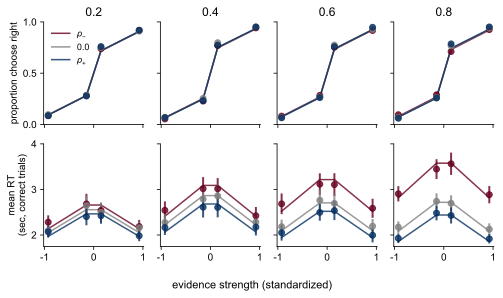

In [35]:
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#horizontal version. 
fig,ax=plt.subplots(nrows=2,ncols=4,sharex=True)
#then plot best fit model only against data separately per corr cond
for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,datat_mshared_psycho_ave_all.groupby('rho_cond'),
                               datat_mshared_chrono_ave_all.groupby('rho_cond')):
    assert rcp==rcc
    #print(rcp)
    dfp_r.reset_index(level='rho_cond',drop=True,inplace=True)
    dfc_r.reset_index(level='rho_cond',drop=True,inplace=True)
    plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix='_best',
                                   alpha=0.8,RT_err=False,ax=axi,ax_labels=False)
    
    axi[0].set_ylim((0,1))
    axi[0].set_xticks([-1.0,0.0,1.0]) #this is redundant b/c sharex is on, but leaving
    axi[0].set_xticklabels([])
    axi[0].set_yticks([0,0.5,1])
    axi[0].set_title(rcp)
    if rcp==0.2:
        axi[0].legend(labels=(r'$\rho_{\minus}$','0.0',r'$\rho_{\plus}$'),
                      frameon=False,fontsize=9)
    else:
        axi[0].legend().set_visible(False)
    #axi[1].set_yticks([2,3])
    axi[1].set_xticks([-1.0,0.0,1.0])
    axi[1].set_xticklabels([-1,0,1])
    
    axi[1].locator_params(nbins=3, axis='y')
    axi[1].set_ylim((1.75,4))
    
    if rcp > 0.2:
        axi[0].set_yticklabels([])
        axi[1].set_yticklabels([])

        
fig.supxlabel('evidence strength (standardized)')
ax[0,0].set_ylabel('proportion choose right')
ax[1,0].set_ylabel('mean RT\n(sec, correct trials)')
fig.set_figwidth(18*cm)
fig.set_figheight(10.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig6_fit_preds_%s.pdf' % date.today()))

print(fig.get_figwidth())
print(fig.get_figheight())

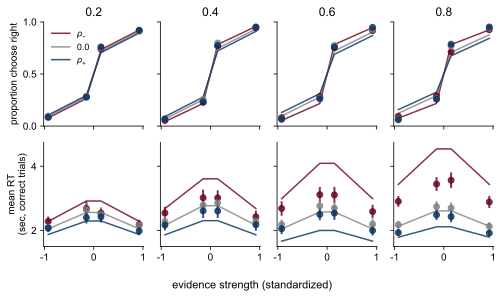

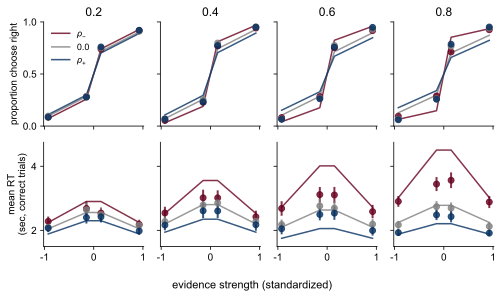

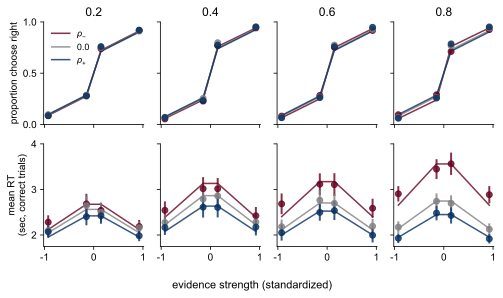

In [36]:
#plot illustrative subset of models for supp
supp_mods = ['_rsharedCLT','_bound_sharedCLT_vk','_bound_rscaleCLT_sk']

for mm in supp_mods:
    fig,ax=plt.subplots(nrows=2,ncols=4,sharex=True)
    #then plot best fit model only against data separately per corr cond
    for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,datat_mshared_psycho_ave_all.groupby('rho_cond'),
                                   datat_mshared_chrono_ave_all.groupby('rho_cond')):
        assert rcp==rcc
        #print(rcp)
        dfp_r.reset_index(level='rho_cond',drop=True,inplace=True)
        dfc_r.reset_index(level='rho_cond',drop=True,inplace=True)
        plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix=mm,
                                       alpha=0.8,RT_err=False,ax=axi,ax_labels=False)

        axi[0].set_ylim((0,1))
        axi[0].set_xticks([-1.0,0.0,1.0]) #this is redundant b/c sharex is on, but leaving
        axi[0].set_xticklabels([])
        axi[0].set_yticks([0,0.5,1])
        axi[0].set_title(rcp)
        if rcp==0.2:
            axi[0].legend(labels=(r'$\rho_{\minus}$','0.0',r'$\rho_{\plus}$'),
                          frameon=False,fontsize=9)
            #axi[0].set_title(str(rcp)+mm)
        else:
            axi[0].legend().set_visible(False)
        #axi[1].set_yticks([2,3])
        axi[1].set_xticks([-1.0,0.0,1.0])
        axi[1].set_xticklabels([-1,0,1])

        axi[1].locator_params(nbins=3, axis='y')
        if 'shared' in mm:
            axi[1].set_ylim((1.5,4.75))
        else:
            axi[1].set_ylim((1.75,4))

        if rcp > 0.2:
            axi[0].set_yticklabels([])
            axi[1].set_yticklabels([])


    fig.supxlabel('evidence strength (standardized)')
    ax[0,0].set_ylabel('proportion choose right')
    ax[1,0].set_ylabel('mean RT\n(sec, correct trials)')
    fig.set_figwidth(18*cm)
    fig.set_figheight(10.5*cm)
    fig.tight_layout()

    fig.savefig(path.join(fig_dir,'fig6_fit_preds%s_%s.pdf' % (mm, date.today())))

### Now generate "ideal" predictions"
Keeping all other parameters fixed, what is predicted performance if using true corr for each subject/condition. We can use this to evaluate how much better subjects could have done.

We will also generate naive predictions to show how much worse they could have done to provide scale for the ideal comparison.

In [37]:
#for best model, create a copy with true correlation params
ideal_mods = ['bound_rscaleCLT_vrh']
ideal_tdur = 15 #match data
ideal_fits = {}
for r,v in shared_fits.items():
    ideal_fits[r] = {}
    for m in ideal_mods:
        f_ideal = copy.deepcopy(shared_fits[r][m])
        for smod in f_ideal.values():
            
            #set correlations to their true values
            sbound = smod.get_dependence('Bound')
            setattr(sbound,'Rn',-r)
            setattr(sbound,'Rp',r)
            
            sdrift = smod.get_dependence('Drift')
            if hasattr(sdrift,'Rn'):
                setattr(sdrift,'Rn',-r)
                setattr(sdrift,'Rp',r)
            
            smod.T_dur = ideal_tdur
            
        
        #save to dict
        ideal_fits[r][m] = f_ideal

In [38]:
do_sols = False

if do_sols:
    ideal_soldf = {k:{} for k in ideal_mods}
    for (sk,sv),(mk,mv) in zip(shared_samps.items(),ideal_fits.items()):
        assert sk==mk
        print(sk)
        #print(sv)
        #ideal_soldf[sk] = {}
        for mvn,mvi in mv.items():
            print(mvn)
            soldf = ddm_corr.get_all_sols(sv,mvi,forced=False,renorm=True)
            #soldf = {}
            soldf['rho_cond'] = sk
            soldf['model'] = mvn
            #print(soldf)
            
            ideal_soldf[mvn][sk] = soldf
            
    with open(path.join(fit_dir,'ideal_sols_unforced_tdur15_%s' % date.today()),'wb') as f:
        pickle.dump(ideal_soldf,f)
else:
    with open(path.join(fit_dir,'ideal_sols_unforced_tdur15_2025-01-20'),'rb') as f:
        ideal_soldf = pickle.load(f)

#These are probably overkill and some guaranteed to pass, but better safe than sorry...   
assert len(ideal_soldf)==len(ideal_mods), "Not all model sols present!"
assert np.array_equal(list(ideal_soldf.keys()),ideal_mods), "Not all model sols present!"
assert np.all(np.array([len(f.keys()) for f in ideal_soldf.values()])==len(rho_conds)), "Not all rho_conds present for all model types!"
assert np.all(np.array([len(y.subject.unique()) for x in ideal_soldf.values() for y in x.values()])==25), 'Incorrect number of subjects in solutions'
assert np.all(np.array([y.groupby('subject').size().unique() for x in ideal_soldf.values() for y in x.values()])==12), 'Incorrect number of solutions per subject'

ideal_soldf = {k:pd.concat(v,ignore_index=True).set_index(['subject','rho_cond']) for k,v in ideal_soldf.items()}
ideal_soldf

{'bound_rscaleCLT_vrh':                                    rho       mu  mean_corr  mean_err  \
 subject                  rho_cond                                      
 5f30ee4c383a0d56521f69c7 0.2       0.0 -0.02818   0.732968  0.267032   
                          0.2       0.2 -0.03088   0.733034  0.266966   
                          0.2       0.2 -0.07719   0.921122  0.078878   
                          0.2      -0.2  0.06302   0.921108  0.078892   
                          0.2      -0.2 -0.02521   0.733007  0.266993   
 ...                                ...      ...        ...       ...   
 5f45613cde4a9714259f31fc 0.8      -0.8  0.00788   0.686900  0.313100   
                          0.8       0.0 -0.04408   0.877429  0.122571   
                          0.8      -0.8  0.01971   0.877395  0.122605   
                          0.8       0.8  0.02365   0.686972  0.313028   
                          0.8       0.8  0.05914   0.877431  0.122569   
 
                          

In [39]:
for df in ideal_soldf.values():
    assert (df.groupby('subject').count()==12).all().all(), 'Incorrect number of conditions detected in solution!'

In [40]:
#let's also compute the naive predictions to give a better sense of scale for how good subjects are
#for best models, create a copy with zero correlation params
naive_fits = {}
#don't restrict tdur based on RT cutoffs here cause we want to show how different a prediction this is 
#(i.e., outside the range of most of our data)
naive_tdur = 60 #max time in task
for r,v in shared_fits.items():
    naive_fits[r] = {}
    for m in ideal_mods:
        f_naive = copy.deepcopy(shared_fits[r][m])
        for smod in f_naive.values():
            
            #set bound scaling correlations to zero. Requires replacing the bound with a more flexible version.
            sbound = smod.get_dependence('Bound') 
            f_params = {x:getattr(sbound,x) for x in sbound.required_parameters} #get fit params
            new_bound = models_corr.BoundR2ScaleCollapsingLinearT(RnB=0.,RpB=0.,**f_params)
            smod._bounddep = new_bound #risky!
            
            smod.T_dur = naive_tdur
        
        #save to dict
        naive_fits[r][m] = f_naive

In [41]:
do_sols = False

if do_sols:
    naive_soldf = {k:{} for k in ideal_mods}
    for (sk,sv),(mk,mv) in zip(shared_samps.items(),naive_fits.items()):
        assert sk==mk
        print(sk)
        #print(sv)
        #naive_soldf[sk] = {}
        for mvn,mvi in mv.items():
            print(mvn)
            soldf = ddm_corr.get_all_sols(sv,mvi,forced=False,renorm=True)
            #soldf = {}
            soldf['rho_cond'] = sk
            soldf['model'] = mvn
            #print(soldf)
            
            naive_soldf[mvn][sk] = soldf
            
    with open(path.join(fit_dir,'naive_sols_unforced_tdur60_%s' % date.today()),'wb') as f:
        pickle.dump(naive_soldf,f)
else:
    with open(path.join(fit_dir,'naive_sols_unforced_tdur60_2025-01-21'),'rb') as f:
        naive_soldf = pickle.load(f)
        
#These are probably overkill and some guaranteed to pass, but better safe than sorry...   
assert len(naive_soldf)==len(ideal_mods), "Not all model sols present!"
assert np.array_equal(list(naive_soldf.keys()),ideal_mods), "Not all model sols present!"
assert np.all(np.array([len(f.keys()) for f in naive_soldf.values()])==len(rho_conds)), "Not all rho_conds present for all model types!"
assert np.all(np.array([len(y.subject.unique()) for x in naive_soldf.values() for y in x.values()])==25), 'Incorrect number of subjects in solutions'
assert np.all(np.array([y.groupby('subject').size().unique() for x in naive_soldf.values() for y in x.values()])==12), 'Incorrect number of solutions per subject'

naive_soldf = {k:pd.concat(v,ignore_index=True).set_index(['subject','rho_cond']) for k,v in naive_soldf.items()}
naive_soldf

{'bound_rscaleCLT_vrh':                                    rho       mu  mean_corr  mean_err  \
 subject                  rho_cond                                      
 5f30ee4c383a0d56521f69c7 0.2       0.0 -0.02818   0.732968  0.267032   
                          0.2       0.2 -0.03088   0.704268  0.295732   
                          0.2       0.2 -0.07719   0.893743  0.106257   
                          0.2      -0.2  0.06302   0.946149  0.053851   
                          0.2      -0.2 -0.02521   0.767873  0.232127   
 ...                                ...      ...        ...       ...   
 5f45613cde4a9714259f31fc 0.8      -0.8  0.00788   0.892990  0.107010   
                          0.8       0.0 -0.04408   0.877429  0.122571   
                          0.8      -0.8  0.01971   0.993844  0.006156   
                          0.8       0.8  0.02365   0.630968  0.369032   
                          0.8       0.8  0.05914   0.792510  0.207490   
 
                          

In [43]:
for df in naive_soldf.values():
    assert (df.groupby('subject').count()==12).all().all(), 'Incorrect number of conditions detected in solution!'

In [44]:
#in this analysis we want to use mean_corr not pred_response, so need to add that in 
#(maybe would be easier to do this above) but would add a lot of junk we don't need...
datat_msharedid = datat_mshared

for m in ideal_mods:
    datat_msharedid = datat_msharedid.merge(datat_mshared_dict[m][['rho_cond','subject','trial','mean_corr']],
                                                         on=['rho_cond','subject','trial'],
                                                          validate='1:1')
    datat_msharedid.rename({'mean_corr':'mean_corr' + '_' + m},axis=1,inplace=True)

In [45]:
#more merging, wheee!

pred_dict = {'ideal': ideal_soldf, 'naive': naive_soldf}

#datat_msharedid = datat_mshared
pred_cols = ['mean_RT_corr','mean_RT_err','mean_corr'] #'pred_response']

for pr,prdf in pred_dict.items():
    for m,df in prdf.items():

        datat_msharedid = ddm_corr.data_pred_merge(datat_msharedid,df,
                           on=['subject','rho_cond','rho','mu'])

        new_cols = [col + '_' + m + '_' + pr for col in pred_cols]
        #datat_msharedid = datat_msharedid.rename(dict(zip(pred_cols,new_cols)),axis=1).drop(['mean_corr','mean_err','model'],axis=1)
        datat_msharedid = datat_msharedid.rename(dict(zip(pred_cols,new_cols)),axis=1).drop(['pred_response','mean_err','model'],axis=1)

display(datat_msharedid.head())
print(datat_msharedid.columns)

   trial                   subject  rho       mu      RT  response  correct  \
0      1  5f3ee36d0306de1a411882a5  0.2  0.02069  1.6825       1.0      1.0   
1     18  5f3ee36d0306de1a411882a5  0.2  0.02069  2.9287       1.0      1.0   
2     36  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6330       0.0      0.0   
3     40  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6890       1.0      1.0   
4     59  5f3ee36d0306de1a411882a5  0.2  0.02069  1.7222       0.0      0.0   

     SNRraw  threshold  rho_cond  ...  mean_RT_corr_best  mean_RT_err_best  \
0  0.142692   0.356901       0.2  ...           2.676869           2.91886   
1  0.142692   0.356901       0.2  ...           2.676869           2.91886   
2  0.142692   0.356901       0.2  ...           2.676869           2.91886   
3  0.142692   0.356901       0.2  ...           2.676869           2.91886   
4  0.142692   0.356901       0.2  ...           2.676869           2.91886   

   pred_response_best  mean_corr_bound_rscaleCLT_vrh  me

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,mean_RT_corr_best,mean_RT_err_best,pred_response_best,mean_corr_bound_rscaleCLT_vrh,mean_corr_bound_rscaleCLT_vrh_ideal,mean_RT_corr_bound_rscaleCLT_vrh_ideal,mean_RT_err_bound_rscaleCLT_vrh_ideal,mean_corr_bound_rscaleCLT_vrh_naive,mean_RT_corr_bound_rscaleCLT_vrh_naive,mean_RT_err_bound_rscaleCLT_vrh_naive
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,2.676869,2.91886,0.742174,0.742174,0.741881,2.716822,2.961167,0.716259,2.595935,3.305427
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,2.676869,2.91886,0.742174,0.742174,0.741881,2.716822,2.961167,0.716259,2.595935,3.305427
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,2.676869,2.91886,0.742174,0.742174,0.741881,2.716822,2.961167,0.716259,2.595935,3.305427
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,2.676869,2.91886,0.742174,0.742174,0.741881,2.716822,2.961167,0.716259,2.595935,3.305427
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,2.676869,2.91886,0.742174,0.742174,0.741881,2.716822,2.961167,0.716259,2.595935,3.305427


Index(['trial', 'subject', 'rho', 'mu', 'RT', 'response', 'correct', 'SNRraw',
       'threshold', 'rho_cond', 'SNR', 'mean_RT_corr_rsharedCLT',
       'mean_RT_err_rsharedCLT', 'pred_response_rsharedCLT',
       'pred_response_bound_rscaleCLT_sk', 'mean_RT_corr_bound_rscaleCLT_sk',
       'mean_RT_err_bound_rscaleCLT_sk', 'pred_response_bound_sharedCLT_vk',
       'mean_RT_corr_bound_sharedCLT_vk', 'mean_RT_err_bound_sharedCLT_vk',
       'pred_response_bound_rscaleCLT_vrh', 'mean_RT_corr_bound_rscaleCLT_vrh',
       'mean_RT_err_bound_rscaleCLT_vrh', 'pred_response_bound_rscaleCLT_vr2',
       'mean_RT_corr_bound_rscaleCLT_vr2', 'mean_RT_err_bound_rscaleCLT_vr2',
       'pred_response_bound_rscaleCLT_vk', 'mean_RT_corr_bound_rscaleCLT_vk',
       'mean_RT_err_bound_rscaleCLT_vk', 'mean_RT_corr_best',
       'mean_RT_err_best', 'pred_response_best',
       'mean_corr_bound_rscaleCLT_vrh', 'mean_corr_bound_rscaleCLT_vrh_ideal',
       'mean_RT_corr_bound_rscaleCLT_vrh_ideal',
       'm

In [46]:
#compute columns for best-fitting ideal/naive model (based on fit stats). 

#mean_corr fitted
datat_msharedid['mean_corr_best'] = datat_msharedid['mean_corr_bound_rscaleCLT_vrh']
assert datat_msharedid['mean_corr_bound_rscaleCLT_vrh'].equals(\
    datat_msharedid['mean_corr_best'])

#model predictions for ideal/naive
for pr in pred_dict.keys():
    datat_msharedid['mean_RT_corr_best_' + pr] = datat_msharedid['mean_RT_corr_bound_rscaleCLT_vrh_' + pr] 
    assert datat_msharedid['mean_RT_corr_bound_rscaleCLT_vrh_' + pr].equals(datat_msharedid['mean_RT_corr_best_' + pr])

    datat_msharedid['mean_RT_err_best_' + pr] = datat_msharedid['mean_RT_err_bound_rscaleCLT_vrh_' + pr] 
    assert datat_msharedid['mean_RT_err_bound_rscaleCLT_vrh_' + pr].equals(datat_msharedid['mean_RT_err_best_' + pr])
    
    datat_msharedid['mean_corr_best_' + pr] = datat_msharedid['mean_corr_bound_rscaleCLT_vrh_' + pr] 
    assert datat_msharedid['mean_corr_bound_rscaleCLT_vrh_' + pr].equals(datat_msharedid['mean_corr_best_' + pr])

    
display(datat_msharedid.head())
print(datat_msharedid.columns)

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,mean_corr_bound_rscaleCLT_vrh_naive,mean_RT_corr_bound_rscaleCLT_vrh_naive,mean_RT_err_bound_rscaleCLT_vrh_naive,mean_corr_best,mean_RT_corr_best_ideal,mean_RT_err_best_ideal,mean_corr_best_ideal,mean_RT_corr_best_naive,mean_RT_err_best_naive,mean_corr_best_naive
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,0.716259,2.595935,3.305427,0.742174,2.716822,2.961167,0.741881,2.595935,3.305427,0.716259
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,0.716259,2.595935,3.305427,0.742174,2.716822,2.961167,0.741881,2.595935,3.305427,0.716259
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,0.716259,2.595935,3.305427,0.742174,2.716822,2.961167,0.741881,2.595935,3.305427,0.716259
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,0.716259,2.595935,3.305427,0.742174,2.716822,2.961167,0.741881,2.595935,3.305427,0.716259
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,0.716259,2.595935,3.305427,0.742174,2.716822,2.961167,0.741881,2.595935,3.305427,0.716259


Index(['trial', 'subject', 'rho', 'mu', 'RT', 'response', 'correct', 'SNRraw',
       'threshold', 'rho_cond', 'SNR', 'mean_RT_corr_rsharedCLT',
       'mean_RT_err_rsharedCLT', 'pred_response_rsharedCLT',
       'pred_response_bound_rscaleCLT_sk', 'mean_RT_corr_bound_rscaleCLT_sk',
       'mean_RT_err_bound_rscaleCLT_sk', 'pred_response_bound_sharedCLT_vk',
       'mean_RT_corr_bound_sharedCLT_vk', 'mean_RT_err_bound_sharedCLT_vk',
       'pred_response_bound_rscaleCLT_vrh', 'mean_RT_corr_bound_rscaleCLT_vrh',
       'mean_RT_err_bound_rscaleCLT_vrh', 'pred_response_bound_rscaleCLT_vr2',
       'mean_RT_corr_bound_rscaleCLT_vr2', 'mean_RT_err_bound_rscaleCLT_vr2',
       'pred_response_bound_rscaleCLT_vk', 'mean_RT_corr_bound_rscaleCLT_vk',
       'mean_RT_err_bound_rscaleCLT_vk', 'mean_RT_corr_best',
       'mean_RT_err_best', 'pred_response_best',
       'mean_corr_bound_rscaleCLT_vrh', 'mean_corr_bound_rscaleCLT_vrh_ideal',
       'mean_RT_corr_bound_rscaleCLT_vrh_ideal',
       'm

In [47]:
#compute differences between ideal predictions and behavior for psycho and chrono and plot
modid_cols_resp = ['mean_corr_best','mean_corr_best_ideal','mean_corr_best_naive'] #['pred_response_best','pred_response_best_ideal'] #just this for now
modid_cols_RT = ['mean_RT_corr_best','mean_RT_err_best',
                 'mean_RT_corr_best_ideal','mean_RT_err_best_ideal',
                'mean_RT_corr_best_naive','mean_RT_err_best_naive']

#first subject averages
datat_msharedid_psycho_ave = \
    datat_msharedid[['subject','rho_cond','rho','SNR','mu','response','correct']+modid_cols_resp].groupby(['subject','rho_cond','rho','SNR','mu']).agg(['mean','std','sem'])

datat_msharedid_chrono_ave = \
    datat_msharedid[['subject','rho_cond','rho','SNR','mu','correct','RT']+modid_cols_RT].groupby(['subject','rho_cond','rho','SNR','mu','correct']).agg(['mean','std','sem'])

#display(datat_msharedid_psycho_ave.groupby('rho_cond').head())
#display(datat_msharedid_chrono_ave.groupby('rho_cond').head())

#datat_msharedid_psycho_ave['response_diff','mean'] = \
#    datat_msharedid_psycho_ave['pred_response_best','mean'] - datat_msharedid_psycho_ave['pred_response_best_ideal','mean']

In [48]:
#difference between true expected performance and ideal
datat_msharedid_psycho_ave['corr_diff_ideal','mean'] = \
    datat_msharedid_psycho_ave['mean_corr_best','mean'] - datat_msharedid_psycho_ave['mean_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_corr_diff_ideal','mean'] = \
    datat_msharedid_chrono_ave['mean_RT_corr_best','mean'] - datat_msharedid_chrono_ave['mean_RT_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_err_diff_ideal','mean'] = \
    datat_msharedid_chrono_ave['mean_RT_err_best','mean'] - datat_msharedid_chrono_ave['mean_RT_err_best_ideal','mean']

#difference between expected naive and ideal performance (naming convention now gets a little weird but will stet)
datat_msharedid_psycho_ave['corr_diff_naive','mean'] = \
    datat_msharedid_psycho_ave['mean_corr_best_naive','mean'] - datat_msharedid_psycho_ave['mean_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_corr_diff_naive','mean'] = \
    datat_msharedid_chrono_ave['mean_RT_corr_best_naive','mean'] - datat_msharedid_chrono_ave['mean_RT_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_err_diff_naive','mean'] = \
    datat_msharedid_chrono_ave['mean_RT_err_best_naive','mean'] - datat_msharedid_chrono_ave['mean_RT_err_best_ideal','mean']


#difference between ACTUAL PERFORMANCE and ideal
datat_msharedid_psycho_ave['corr_diff_actual_ideal','mean'] = \
    datat_msharedid_psycho_ave['correct','mean'] - datat_msharedid_psycho_ave['mean_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_corr_diff_actual_ideal','mean'] = \
    datat_msharedid_chrono_ave['RT','mean'] - datat_msharedid_chrono_ave['mean_RT_corr_best_ideal','mean']

datat_msharedid_chrono_ave['RT_err_diff_actual_ideal','mean'] = \
    datat_msharedid_chrono_ave['RT','mean'] - datat_msharedid_chrono_ave['mean_RT_err_best_ideal','mean']

#difference between ACTUAL PERFORMANCE and PREDICTED
datat_msharedid_psycho_ave['corr_diff_actual_best','mean'] = \
    datat_msharedid_psycho_ave['correct','mean'] - datat_msharedid_psycho_ave['mean_corr_best','mean']

datat_msharedid_chrono_ave['RT_corr_diff_actual_best','mean'] = \
    datat_msharedid_chrono_ave['RT','mean'] - datat_msharedid_chrono_ave['mean_RT_corr_best','mean']

datat_msharedid_chrono_ave['RT_err_diff_actual_best','mean'] = \
    datat_msharedid_chrono_ave['RT','mean'] - datat_msharedid_chrono_ave['mean_RT_err_best','mean']


display(datat_msharedid_psycho_ave.groupby('rho_cond').head())
display(datat_msharedid_chrono_ave.groupby('rho_cond').head())

response            \
                                                           mean       std   
subject                  rho_cond rho  SNR   mu                             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.109375  0.314576   
                                       -0.12 -0.01340  0.359375  0.483610   
                                        0.12  0.01340  0.703125  0.460493   
                                        0.75  0.03350  0.984375  0.125000   
                                   0.0 -0.75 -0.04325  0.109375  0.314576   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.066667  0.251549   
                                       -0.12 -0.00759  0.403226  0.494550   
                                        0.12  0.00759  0.796875  0.405505   
                                        0.72  0.01897  0.951613  0.216335   
                                   0.0 -0.72 -0.04241  0.015625  0.125000   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.078125  0.270490   
                                       -0.14 -0.01195  0.406250  0.495015   
                                        0.14  0.01195  0.796875  0.405505   
                                        0.89  0.02987  0.953125  0.213042   
                                   0.0 -0.89 -0.04723  0.234375  0.426956   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.062500  0.243975   
                                       -0.13 -0.01606  0.281250  0.453163   
                                        0.13  0.01606  0.734375  0.445157   
                                        0.81  0.04015  0.984375  0.125000   
                                   0.0 -0.81 -0.04489  0.031250  0.175368   

                                                                  correct  \
                                                            sem      mean   
subject                  rho_cond rho  SNR   mu                             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.039322  0.890625   
                                       -0.12 -0.01340  0.060451  0.640625   
                                        0.12  0.01340  0.057562  0.703125   
                                        0.75  0.03350  0.015625  0.984375   
                                   0.0 -0.75 -0.04325  0.039322  0.890625   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.032475  0.933333   
                                       -0.12 -0.00759  0.062808  0.596774   
                                        0.12  0.00759  0.050688  0.796875   
                                        0.72  0.01897  0.027475  0.951613   
                                   0.0 -0.72 -0.04241  0.015625  0.984375   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.033811  0.921875   
                                       -0.14 -0.01195  0.061877  0.593750   
                                        0.14  0.01195  0.050688  0.796875   
                                        0.89  0.02987  0.026630  0.953125   
                                   0.0 -0.89 -0.04723  0.053370  0.765625   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.030497  0.937500   
                                       -0.13 -0.01606  0.056645  0.718750   
                                        0.13  0.01606  0.055645  0.734375   
                                        0.81  0.04015  0.015625  0.984375   
                                   0.0 -0.81 -0.04489  0.021921  0.968750   

                                                                           \
                                                            std       sem   
subject                  rho_cond rho  SNR   mu                             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.314576  0.039322   
                                       -0.12 -0.01340  0.483610  0.060451   
                                        0.12  0.01340  0.460493  0.057562   
                                        0.75  0.0

RT  \
                                                                   mean   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      3.605714   
                                                      1.0      2.734781   
                                       -0.12 -0.01340 0.0      3.086874   
                                                      1.0      2.946388   
                                        0.12  0.01340 0.0      2.496626   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      3.699500   
                                                      1.0      2.911679   
                                       -0.12 -0.00759 0.0      3.611480   
                                                      1.0      3.066297   
                                        0.12  0.00759 0.0      3.047923   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      4.957400   
                                                      1.0      2.915008   
                                       -0.14 -0.01195 0.0      3.624435   
                                                      1.0      3.045018   
                                        0.14  0.01195 0.0      2.876669   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      2.806550   
                                                      1.0      1.994917   
                                       -0.13 -0.01606 0.0      2.689339   
                                                      1.0      2.041659   
                                        0.13  0.01606 0.0      2.491012   

                                                                         \
                                                                    std   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.856701   
                                                      1.0      0.882488   
                                       -0.12 -0.01340 0.0      1.135117   
                                                      1.0      1.004948   
                                        0.12  0.01340 0.0      0.843780   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      1.988548   
                                                      1.0      1.699150   
                                       -0.12 -0.00759 0.0      1.743437   
                                                      1.0      1.279710   
                                        0.12  0.00759 0.0      0.833213   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      2.912065   
                                                      1.0      1.176968   
                                       -0.14 -0.01195 0.0      2.355111   
                                                      1.0      1.676974   
                                        0.14  0.01195 0.0      1.571359   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      1.100412   
                                                      1.0      0.671982   
                                       -0.13 -0.01606 0.0      0.793360   
                                                      1.0      0.551630   
                                        0.13  0.01606 0.0      0.884248   

                                                                         \
                                                                    sem   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      0.701767   
                                                      1.0      0.116888   
                                       -0.12 -0.01340 0.0      0.236688   
                                                      1.0      0.156947   
                                        0.12  0.01340 0.0      0.193576   
58f82417edbd82000

In [49]:
#let's look by SNR (averaged over source)
subj_SNR['auSNR'] = subj_SNR['uSNR'].abs()

datat_msharedid_psycho_ave2 = datat_msharedid_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['subject','rho_cond','rho','auSNR']).agg('mean')
datat_msharedid_chrono_ave2 = datat_msharedid_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['subject','rho_cond','rho','auSNR','correct']).agg('mean')

display(datat_msharedid_psycho_ave2)
display(datat_msharedid_chrono_ave2)

datat_msharedid_psycho_ave_all = \
    datat_msharedid_psycho_ave2.groupby(['rho_cond','rho','auSNR']).agg(['mean','std','sem'])
display(datat_msharedid_psycho_ave_all)

datat_msharedid_chrono_ave_all = \
    datat_msharedid_chrono_ave2.groupby(['rho_cond','rho','auSNR','correct']).agg(['mean','std','sem'])
display(datat_msharedid_chrono_ave_all)

#need to handle zero corr separately, since want to average it over all rho conds
datat_msharedid_psycho_ave_r0 = \
    datat_msharedid_psycho_ave2.xs(0.0,axis=0,level=2).groupby('auSNR').agg(['mean','std','sem'])
display(datat_msharedid_psycho_ave_r0)

datat_msharedid_chrono_ave_r0 = \
    datat_msharedid_chrono_ave2.xs(0.0,axis=0,level=2).groupby(['auSNR','correct']).agg(['mean','std','sem'])
display(datat_msharedid_chrono_ave_r0)

response   correct  \
subject                  rho_cond rho  auSNR                        
575f387c91f8b40006c332e1 0.4      -0.4 0.1480  0.531250  0.671875   
                                       0.9239  0.546875  0.937500   
                                   0.0 0.1480  0.656250  0.750000   
                                       0.9239  0.539062  0.929688   
                                   0.4 0.1480  0.562500  0.781250   
...                                                 ...       ...   
6176846e673909995a32dce3 0.6      -0.6 0.9239  0.515625  0.828125   
                                   0.0 0.1480  0.523438  0.632812   
                                       0.9239  0.515625  0.921875   
                                   0.6 0.1480  0.539062  0.664062   
                                       0.9239  0.546875  0.859375   

                                               mean_corr_best  \
subject                  rho_cond rho  auSNR                    
575f387c91f8b40006c332e1 0.4      -0.4 0.1480        0.695299   
                                       0.9239        0.896818   
                                   0.0 0.1480        0.705532   
                                       0.9239        0.908533   
                                   0.4 0.1480        0.711739   
...                                                       ...   
6176846e673909995a32dce3 0.6      -0.6 0.9239        0.846923   
                                   0.0 0.1480        0.668205   
                                       0.9239        0.857609   
                                   0.6 0.1480        0.670348   
                                       0.9239        0.860574   

                                               mean_corr_best_ideal  \
subject                  rho_cond rho  auSNR                          
575f387c91f8b40006c332e1 0.4      -0.4 0.1480              0.705525   
                                       0.9239              0.908525   
                                   0.0 0.1480              0.705532   
                                       0.9239              0.908533   
                                   0.4 0.1480              0.705535   
...                                                             ...   
6176846e673909995a32dce3 0.6      -0.6 0.9239              0.857604   
                                   0.0 0.1480              0.668205   
                                       0.9239              0.857609   
                                   0.6 0.1480              0.668206   
                                       0.9239              0.857604   

                                               mean_corr_best_naive  \
subject                  rho_cond rho  auSNR                          
575f387c91f8b40006c332e1 0.4      -0.4 0.1480              0.714420   
                                       0.9239              0.920021   
                                   0.0 0.1480              0.705532   
                                       0.9239              0.908533   
                                   0.4 0.1480              0.691313   
...                                                             ...   
6176846e673909995a32dce3 0.6      -0.6 0.9239              0.914146   
                                   0.0 0.1480              0.668205   
                                       0.9239              0.857609   
                                   0.6 0.1480              0.629985   
                                       0.9239              0.793069   

                                               corr_diff_ideal  \
subject                  rho_cond rho  auSNR                     
575f387c91f8b40006c332e1 0.4      -0.4 0.1480        -0.010226   
                                       0.9239        -0.011708   
                                   0.0 0.1480         0.000000   
                                       0.9239         0.000000   
                                   0.4 0.1480         0.006

RT  \
subject                  rho_cond rho  auSNR  correct             
575f387c91f8b40006c332e1 0.4      -0.4 0.1480 0.0      2.791750   
                                              1.0      2.971501   
                                       0.9239 0.0      2.325007   
                                              1.0      2.673569   
                                   0.0 0.1480 0.0      3.204352   
...                                                         ...   
6176846e673909995a32dce3 0.6       0.0 0.9239 1.0      0.893910   
                                   0.6 0.1480 0.0      0.885141   
                                              1.0      0.938760   
                                       0.9239 0.0      1.172029   
                                              1.0      0.860405   

                                                       mean_RT_corr_best  \
subject                  rho_cond rho  auSNR  correct                      
575f387c91f8b40006c332e1 0.4      -0.4 0.1480 0.0               3.005695   
                                              1.0               3.005695   
                                       0.9239 0.0               2.640688   
                                              1.0               2.640688   
                                   0.0 0.1480 0.0               2.780920   
...                                                                  ...   
6176846e673909995a32dce3 0.6       0.0 0.9239 1.0               0.904020   
                                   0.6 0.1480 0.0               0.970749   
                                              1.0               0.970749   
                                       0.9239 0.0               0.875956   
                                              1.0               0.875956   

                                                       mean_RT_err_best  \
subject                  rho_cond rho  auSNR  correct                     
575f387c91f8b40006c332e1 0.4      -0.4 0.1480 0.0              3.274290   
                                              1.0              3.274290   
                                       0.9239 0.0              3.285081   
                                              1.0              3.285081   
                                   0.0 0.1480 0.0              3.036390   
...                                                                 ...   
6176846e673909995a32dce3 0.6       0.0 0.9239 1.0              1.042395   
                                   0.6 0.1480 0.0              1.025514   
                                              1.0              1.025514   
                                       0.9239 0.0              1.009000   
                                              1.0              1.009000   

                                                       mean_RT_corr_best_ideal  \
subject                  rho_cond rho  auSNR  correct                            
575f387c91f8b40006c332e1 0.4      -0.4 0.1480 0.0                     2.780929   
                                              1.0                     2.780929   
                                       0.9239 0.0                     2.410308   
                                              1.0                     2.410308   
                                   0.0 0.1480 0.0                     2.780920   
...                                                                        ...   
6176846e673909995a32dce3 0.6       0.0 0.9239 1.0                     0.904020   
                                   0.6 0.1480 0.0                     1.000083   
                                              1.0                     1.000083   
                                       0.9239 0.0                     0.904023   
                                              1.0                     0.904023   

                                                       mean_RT_err_best_ideal  \
subject                  rho_cond rho  auSNR  correct                       

response                       correct            \
                          mean       std       sem      mean       std   
rho_cond rho  auSNR                                                      
0.2      -0.2 0.1480  0.511109  0.052714  0.010543  0.727894  0.057672   
              0.9239  0.501256  0.026514  0.005303  0.916005  0.048539   
          0.0 0.1480  0.518188  0.057562  0.011512  0.732576  0.053722   
              0.9239  0.503129  0.026479  0.005296  0.906672  0.057879   
          0.2 0.1480  0.518468  0.050598  0.010120  0.741286  0.052773   
              0.9239  0.502695  0.024854  0.004971  0.917023  0.042961   
0.4      -0.4 0.1480  0.498541  0.072267  0.014453  0.770746  0.080014   
              0.9239  0.497500  0.028224  0.005645  0.943889  0.036118   
          0.0 0.1480  0.525908  0.075712  0.015142  0.771713  0.081158   
              0.9239  0.511100  0.025376  0.005075  0.940989  0.036701   
          0.4 0.1480  0.502696  0.062146  0.012429  0.770382  0.079222   
              0.9239  0.508644  0.027788  0.005558  0.941659  0.035203   
0.6      -0.6 0.1480  0.517933  0.059104  0.011821  0.734460  0.056141   
              0.9239  0.499062  0.031037  0.006207  0.917423  0.039075   
          0.0 0.1480  0.521711  0.054938  0.010988  0.752537  0.055715   
              0.9239  0.498420  0.027494  0.005499  0.929991  0.048137   
          0.6 0.1480  0.510156  0.061161  0.012232  0.748277  0.059247   
              0.9239  0.506516  0.025162  0.005032  0.941195  0.034217   
0.8      -0.8 0.1480  0.500546  0.083088  0.016618  0.710934  0.057425   
              0.9239  0.510003  0.030423  0.006085  0.914905  0.048075   
          0.0 0.1480  0.514883  0.065157  0.013031  0.752132  0.054344   
              0.9239  0.504358  0.023769  0.004754  0.937175  0.044113   
          0.8 0.1480  0.521848  0.058059  0.011612  0.764127  0.056716   
              0.9239  0.505967  0.015666  0.003133  0.945349  0.036179   

                               mean_corr_best                      \
                           sem           mean       std       sem   
rho_cond rho  auSNR                                                 
0.2      -0.2 0.1480  0.011534       0.716900  0.043421  0.008684   
              0.9239  0.009708       0.905928  0.043748  0.008750   
          0.0 0.1480  0.010744       0.718033  0.043636  0.008727   
              0.9239  0.011576       0.906888  0.043410  0.008682   
          0.2 0.1480  0.010555       0.720093  0.044973  0.008995   
              0.9239  0.008592       0.908297  0.043897  0.008779   
0.4      -0.4 0.1480  0.016003       0.746316  0.046702  0.009340   
              0.9239  0.007224       0.932849  0.035583  0.007117   
          0.0 0.1480  0.016232       0.749720  0.048742  0.009748   
              0.9239  0.007340       0.934655  0.035371  0.007074   
          0.4 0.1480  0.015844       0.752529  0.049190  0.009838   
              0.9239  0.007041       0.936384  0.035101  0.007020   
0.6      -0.6 0.1480  0.011228       0.732028  0.038375  0.007675   
              0.9239  0.007815       0.921515  0.035401  0.007080   
          0.0 0.1480  0.011143       0.736697  0.038979  0.007796   
              0.9239  0.009627       0.924966  0.034568  0.006914   
          0.6 0.1480  0.011849       0.738547  0.039222  0.007844   
              0.9239  0.006843       0.926243  0.034505  0.006901   
0.8      -0.8 0.1480  0.011485       0.730962  0.040060  0.008012   
              0.9239  0.009615       0.920936  0.032827  0.006565   
          0.0 0.1480  0.010869       0.740447  0.042104  0.008421   
              0.9239  0.008823       0.927647  0.033456  0.006691   
          0.8 0.1480  0.011343       0.743578  0.042486  0.008497   
              0.9239  0.007236       0.929756  0.033238  0.006648   

                     mean_corr_best_ideal  ... corr_diff_actual_ideal  \
                                     mean  ...                    sem   
rho_cond rho 

RT                     mean_RT_corr_best  \
                                  mean       std       sem              mean   
rho_cond rho  auSNR  correct                                                   
0.2      -0.2 0.1480 0.0      2.707958  1.005291  0.201058          2.657660   
                     1.0      2.611488  0.956425  0.191285          2.657660   
              0.9239 0.0      2.316499  0.816512  0.163302          2.137167   
                     1.0      2.233607  0.726921  0.145384          2.137167   
          0.0 0.1480 0.0      2.632023  1.086688  0.217338          2.555890   
                     1.0      2.569144  1.054222  0.210844          2.555890   
              0.9239 0.0      2.293951  0.989077  0.197815          2.050779   
                     1.0      2.127286  0.656028  0.131206          2.050779   
          0.2 0.1480 0.0      2.546959  0.981677  0.196335          2.463317   
                     1.0      2.411781  0.902117  0.180423          2.463317   
              0.9239 0.0      2.193021  1.106467  0.221293          1.969513   
                     1.0      2.026001  0.601253  0.120251          1.969513   
0.4      -0.4 0.1480 0.0      3.328692  1.633076  0.326615          3.088536   
                     1.0      3.015023  1.214539  0.242908          3.088536   
              0.9239 0.0      3.105637  1.639581  0.334678          2.383139   
                     1.0      2.482055  0.953268  0.190654          2.411998   
          0.0 0.1480 0.0      2.871385  1.250145  0.250029          2.864668   
                     1.0      2.823231  1.212919  0.242584          2.864668   
              0.9239 0.0      2.320562  0.928124  0.189453          2.161658   
                     1.0      2.279585  0.908229  0.181646          2.222362   
          0.4 0.1480 0.0      2.785943  1.186484  0.237297          2.679814   
                     1.0      2.607489  1.106355  0.221271          2.679814   
              0.9239 0.0      2.107183  1.215569  0.248127          1.994103   
                     1.0      2.169426  0.862903  0.172581          2.065520   
0.6      -0.6 0.1480 0.0      3.207587  1.326780  0.265356          3.215797   
                     1.0      3.110331  1.202951  0.240590          3.215797   
              0.9239 0.0      2.949156  1.327726  0.265545          2.522141   
                     1.0      2.634747  1.075793  0.215159          2.522141   
          0.0 0.1480 0.0      2.730304  1.159133  0.231827          2.704657   
                     1.0      2.728419  1.072129  0.214426          2.704657   
              0.9239 0.0      2.283727  1.544673  0.315305          2.075504   
                     1.0      2.187827  0.763328  0.152666          2.095222   
          0.6 0.1480 0.0      2.636566  1.075355  0.215071          2.519096   
                     1.0      2.516065  0.953793  0.190759          2.519096   
              0.9239 0.0      1.929348  0.830766  0.166153          1.944029   
                     1.0      2.022055  0.814196  0.162839          1.944029   
0.8      -0.8 0.1480 0.0      3.605614  1.277575  0.255515          3.576073   
                     1.0      3.504080  1.139938  0.227988          3.576073   
              0.9239 0.0      3.005973  1.202744  0.240549          2.815771   
                     1.0      2.894167  0.870164  0.174033          2.815771   
          0.0 0.1480 0.0      2.707036  0.888608  0.177722          2.717684   
                     1.0      2.717903  0.854939  0.170988          2.717684   
              0.9239 0.0      2.090384  0.862174  0.175990          2.049234   
                     1.0      2.149343  0.615557  0.123111          2.082632   
          0.8 0.1480 0.0      2.481411  0.870582  0.174116          2.438728   
                     1.0      2.455390  0.827212  0.165442          2.438728   
              0.9239 0.0      2.200158  1.164596  0.232919          1.858284   
                     1.0      1.9222

response                       correct                      \
            mean       std       sem      mean       std       sem   
auSNR                                                                
0.1480  0.520172  0.063014  0.006301  0.752239  0.062915  0.006291   
0.9239  0.504252  0.025827  0.002583  0.928707  0.048491  0.004849   

       mean_corr_best                     mean_corr_best_ideal  ...  \
                 mean       std       sem                 mean  ...   
auSNR                                                           ...   
0.1480       0.736224  0.044382  0.004438             0.736224  ...   
0.9239       0.923539  0.037778  0.003778             0.923539  ...   

       corr_diff_actual_ideal corr_diff_actual_best                     rSNR  \
                          sem                  mean       std       sem mean   
auSNR                                                                          
0.1480               0.004162              0.016015  0.041619  0.004162  2.5   
0.9239               0.002508              0.005168  0.025077  0.002508  2.5   

                 uSNR            
        std  sem mean  std  sem  
auSNR                            
0.1480  0.0  0.0  0.0  0.0  0.0  
0.9239  0.0  0.0  0.0  0.0  0.0  

[2 rows x 33 columns]

RT                     mean_RT_corr_best            \
                    mean       std       sem              mean       std   
auSNR  correct                                                             
0.1480 0.0      2.735187  1.090813  0.109081          2.710725  0.979883   
       1.0      2.709674  1.044162  0.104416          2.710725  0.979883   
0.9239 0.0      2.247638  1.099585  0.111646          2.083948  0.688007   
       1.0      2.186010  0.735416  0.073542          2.112749  0.701939   

                         mean_RT_err_best                      \
                     sem             mean       std       sem   
auSNR  correct                                                  
0.1480 0.0      0.097988         2.920472  1.094605  0.109461   
       1.0      0.097988         2.920472  1.094605  0.109461   
0.9239 0.0      0.069857         2.667935  0.996717  0.101201   
       1.0      0.070194         2.735318  1.057891  0.105789   

               mean_RT_corr_best_ideal  ... RT_corr_diff_actual_best  \
                                  mean  ...                      sem   
auSNR  correct                          ...                            
0.1480 0.0                    2.710725  ...                 0.036794   
       1.0                    2.710725  ...                 0.020517   
0.9239 0.0                    2.083948  ...                 0.080724   
       1.0                    2.112749  ...                 0.011031   

               RT_err_diff_actual_best                         rSNR            \
                                  mean       std       sem     mean       std   
auSNR  correct                                                                  
0.1480 0.0                   -0.185285  0.361380  0.036138  2.50000  0.000000   
       1.0                   -0.210797  0.272560  0.027256  2.50000  0.000000   
0.9239 0.0                   -0.420297  0.742796  0.075419  2.42268  0.587811   
       1.0                   -0.549308  0.538497  0.053850  2.50000  0.000000   

                              uSNR                      
                     sem      mean       std       sem  
auSNR  correct                                          
0.1480 0.0      0.000000  0.000000  0.000000  0.000000  
       1.0      0.000000  0.000000  0.000000  0.000000  
0.9239 0.0      0.059683 -0.047624  0.362052  0.036761  
       1.0      0.000000  0.000000  0.000000  0.000000  

[4 rows x 51 columns]

6.102362204724409
7.90551181102362


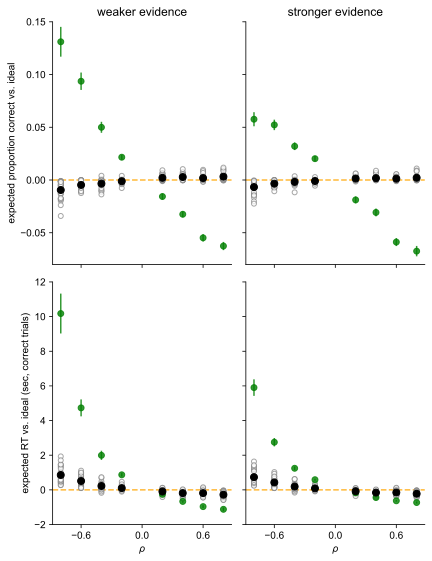

In [50]:
fig,ax=plt.subplots(nrows=2,ncols=2,sharex=True)#,sharey=True)
for axi,(rcp,dfp_r),(rc0,df0),(rcsubj,dfsubj) in zip(ax[0,:],
                                     datat_msharedid_psycho_ave_all.drop(0.0,level='rho').groupby('auSNR'),
                                     datat_msharedid_psycho_ave_r0.groupby('auSNR'),
                                    datat_msharedid_psycho_ave2.drop(0.0,level='rho').groupby('auSNR')):
    
    axi.axhline(0,linestyle='--',color='orange',alpha=0.8)
    
    axi.errorbar(dfp_r.index.get_level_values('rho'), dfp_r[('corr_diff_naive','mean')],
             dfp_r[('corr_diff_naive','sem')],marker='.',linestyle='',color='green',markersize=12,alpha=0.8)
#     axi.errorbar(0,df0[('corr_diff_naive','mean')],
#                  df0[('corr_diff_naive','sem')],
#               marker='.',linestyle='',color='green',markersize=10,alpha=0.8)
    
    axi.errorbar(dfp_r.index.get_level_values('rho'), dfp_r[('corr_diff_ideal','mean')],
             dfp_r[('corr_diff_ideal','sem')],
              marker='.',linestyle='',color='k',markersize=14,)
#     axi.errorbar(0,df0[('corr_diff_ideal','mean')],
#                  df0[('corr_diff_ideal','sem')],
#               marker='.',linestyle='',color='k',markersize=14,)
    
    axi.plot(dfsubj.index.get_level_values('rho'),dfsubj['corr_diff_ideal'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)

    axi.set_ylim((-0.08,0.15))
    axi.set_yticks(np.arange(-0.05,0.155,0.05))
    
#fig,ax=plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
for axi,(rcp,dfp_r),(rc0,df0),(rcsubj,dfsubj) in zip(ax[1,:],
                       datat_msharedid_chrono_ave_all.xs(1,level='correct').drop(0.0,level='rho').groupby('auSNR'),
                        datat_msharedid_chrono_ave_r0.xs(1,level='correct').groupby('auSNR'),
                        datat_msharedid_chrono_ave2.xs(1,level='correct').drop(0.0,level='rho').groupby('auSNR')):
    #display(dfp_r)
    axi.axhline(0,linestyle='--',color='orange',alpha=0.8)
    
    axi.errorbar(dfp_r.index.get_level_values('rho'), dfp_r[('RT_corr_diff_naive','mean')],
                 dfp_r[('RT_corr_diff_naive','sem')],
              marker='.',linestyle='',color='green',markersize=12,alpha=0.8)
#     axi.errorbar(0, df0[('RT_corr_diff_naive','mean')],
#                  df0[('RT_corr_diff_naive','sem')],
#               marker='.',linestyle='',color='green',markersize=10,alpha=0.8)
    
    axi.errorbar(dfp_r.index.get_level_values('rho'), dfp_r[('RT_corr_diff_ideal','mean')],
                 dfp_r[('RT_corr_diff_ideal','sem')],
              marker='.',linestyle='',color='k',markersize=14,)
#     axi.errorbar(0, df0[('RT_corr_diff_ideal','mean')],
#                  df0[('RT_corr_diff_ideal','sem')],
#               marker='.',linestyle='',color='k',markersize=14,)
    
    axi.plot(dfsubj.index.get_level_values('rho'),dfsubj['RT_corr_diff_ideal'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)

    axi.set_ylim((-2,12))
    axi.set_xticks([-0.6,0.0,0.6])
    axi.set_yticks(np.arange(-2,13,2))
    axi.set_xlabel(r'$\rho$')
    

ax[0,0].set_title('weaker evidence');
ax[0,1].set_title('stronger evidence');

ax[0,0].set_ylabel('expected proportion correct vs. ideal')
ax[1,0].set_ylabel('expected RT vs. ideal (sec, correct trials)')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])

fig.set_figwidth(15.5*cm)
fig.set_figheight(20.08*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig7_ideal_diff_%s.pdf' % date.today()))

print(fig.get_figwidth())
print(fig.get_figheight())

In [51]:
if False:
    datat_msharedid_psycho_ave_all.xs('mean',level=1,axis=1).to_csv(path.join(path.join(fit_dir,'Fig7_psycho_data_%s.csv' % date.today())),index=True)
    datat_msharedid_chrono_ave_all.xs('mean',level=1,axis=1).to_csv(path.join(path.join(fit_dir,'Fig7_chrono_data_%s.csv' % date.today())),index=True)   

## fit stats

In [52]:
#look at fit stats
fiteval_shared = [gdw.get_fit_stats(f) 
           for fits in shared_fits.values()
           for m in fits.values() 
           for f in m.values()]
fiteval_shared = pd.DataFrame(fiteval_shared)

#sanity check
assert len(fiteval_shared)==len(subj)*len(shared_mods) 

#we didn't bother with which corr group they were in above, but let's merge that in here in case we want to use it
fiteval_shared = fiteval_shared.merge(subj,on='subject')

#sanity check
assert len(fiteval_shared)==len(subj)*len(shared_mods) 

#display(fiteval_shared)

#output for model comparison in Matlab
if False:
     fiteval_shared.to_csv(path.join(path.join(fit_dir,'shared_fits_all_%s.csv' % date.today())),index=False)    
        
#index for analysis
fiteval_shared = fiteval_shared.set_index(['rho_cond','subject','model'])
display(fiteval_shared)

nparams         nlle  \
rho_cond subject                  model                                       
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT                 5  1467.929824   
                                  bound_rscaleCLT_sk         7  1463.511607   
                                  bound_sharedCLT_vk         7  1467.181299   
                                  bound_rscaleCLT_vrh        7  1462.297815   
                                  bound_rscaleCLT_vr2        9  1466.407640   
...                                                        ...          ...   
0.8      6010b797bbe6be440425665c bound_rscaleCLT_sk         7  1295.252586   
                                  bound_sharedCLT_vk         7  1381.316136   
                                  bound_rscaleCLT_vrh        7  1291.108034   
                                  bound_rscaleCLT_vr2        9  1293.012647   
                                  bound_rscaleCLT_vk         9  1292.213634   

                                                               bic  \
rho_cond subject                  model                              
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT           2969.013066   
                                  bound_rscaleCLT_sk   2973.437997   
                                  bound_sharedCLT_vk   2980.777382   
                                  bound_rscaleCLT_vrh  2971.010414   
                                  bound_rscaleCLT_vr2  2992.491431   
...                                                            ...   
0.8      6010b797bbe6be440425665c bound_rscaleCLT_sk   2636.262012   
                                  bound_sharedCLT_vk   2808.389113   
                                  bound_rscaleCLT_vrh  2627.972909   
                                  bound_rscaleCLT_vr2  2644.855518   
                                  bound_rscaleCLT_vk   2643.257491   

                                                               aic  
rho_cond subject                  model                             
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT           2945.859649  
                                  bound_rscaleCLT_sk   2941.023213  
                                  bound_sharedCLT_vk   2948.362599  
                                  bound_rscaleCLT_vrh  2938.595630  
                                  bound_rscaleCLT_vr2  2950.815280  
...                                                            ...  
0.8      6010b797bbe6be440425665c bound_rscaleCLT_sk   2604.505171  
                                  bound_sharedCLT_vk   2776.632272  
                                  bound_rscaleCLT_vrh  2596.216068  
                                  bound_rscaleCLT_vr2  2604.025293  
                                  bound_rscaleCLT_vk   2602.427267  

[600 rows x 4 columns]

In [53]:
display(fiteval_shared.groupby('model')[['nlle','aic','bic']].agg('mean'))
display(fiteval_shared.groupby(['rho_cond','model'])[['nlle','aic','bic']].agg('mean'))

,nlle,aic,bic
model,,,
bound_rscaleCLT_sk,1415.678996,2845.357992,2877.800029
bound_rscaleCLT_vk,1413.723317,2845.446633,2887.157824
bound_rscaleCLT_vr2,1414.230016,2846.460032,2888.171222
bound_rscaleCLT_vrh,1413.623762,2841.247523,2873.689560
bound_sharedCLT_vk,1482.503852,2979.007704,3011.449741
rsharedCLT,1488.799756,2987.599512,3010.772396


nlle          aic          bic
rho_cond model                                                     
0.2      bound_rscaleCLT_sk   1371.415117  2756.830234  2789.266928
         bound_rscaleCLT_vk   1371.221010  2760.442021  2802.146342
         bound_rscaleCLT_vr2  1371.708366  2761.416731  2803.121052
         bound_rscaleCLT_vrh  1371.330395  2756.660790  2789.097484
         bound_sharedCLT_vk   1376.442680  2766.885360  2799.322054
         rsharedCLT           1376.801229  2763.602459  2786.771526
0.4      bound_rscaleCLT_sk   1357.952275  2729.904550  2762.360032
         bound_rscaleCLT_vk   1358.403099  2734.806197  2776.534674
         bound_rscaleCLT_vr2  1358.287871  2734.575743  2776.304219
         bound_rscaleCLT_vrh  1357.558222  2729.116445  2761.571927
         bound_sharedCLT_vk   1382.528057  2779.056114  2811.511596
         rsharedCLT           1385.712011  2781.424022  2804.606509
0.6      bound_rscaleCLT_sk   1454.655732  2923.311464  2955.762628
         bound_rscaleCLT_vk   1452.201030  2922.402059  2964.124985
         bound_rscaleCLT_vr2  1453.269933  2924.539865  2966.262791
         bound_rscaleCLT_vrh  1452.508835  2919.017670  2951.468835
         bound_sharedCLT_vk   1534.790863  3083.581726  3116.032891
         rsharedCLT           1540.590796  3091.181591  3114.360994
0.8      bound_rscaleCLT_sk   1478.692861  2971.385722  3003.810529
         bound_rscaleCLT_vk   1473.068128  2964.136257  3005.825295
         bound_rscaleCLT_vr2  1473.653894  2965.307787  3006.996825
         bound_rscaleCLT_vrh  1473.097593  2960.195187  2992.619994
         bound_sharedCLT_vk   1636.253808  3286.507617  3318.932424
         rsharedCLT           1652.094988  3314.189976  3337.350553

In [54]:
#load in averaged fit stats, including PEPs, from Matlab VBA toolbox analysis
#fits_shared_ave = pd.read_csv(path.join(fit_dir,'fits_shared_ave_28-Jul-2023.csv'),index_col='model')
#fits_shared_ave_rho = pd.read_csv(path.join(fit_dir,'fits_shared_ave_rho_28-Jul-2023.csv'),index_col=['model','rho_cond'])
fits_shared_ave = pd.read_csv(path.join(fit_dir,'fits_shared_ave_10-Jan-2025.csv'),index_col='model')
fits_shared_ave_rho = pd.read_csv(path.join(fit_dir,'fits_shared_ave_rho_10-Jan-2025.csv'),index_col=['model','rho_cond'])


display(fits_shared_ave)
display(fits_shared_ave_rho)

,GroupCount,mean_nlle,mean_aic,std_nlle,std_aic,sem_nlle,sem_aic,EF,EP,PEP
model,,,,,,,,,,
bound_rscaleCLT_sk,100,1415.678996,2845.357992,312.187402,624.374803,31.218740,62.437480,0.045106,0,5.698591e-36
bound_rscaleCLT_vk,100,1413.723317,2845.446633,311.899296,623.798592,31.189930,62.379859,0.020170,0,5.698591e-36
bound_rscaleCLT_vr2,100,1414.230016,2846.460032,312.152986,624.305973,31.215299,62.430597,0.001660,0,5.698591e-36
bound_rscaleCLT_vrh,100,1413.623762,2841.247523,311.762158,623.524316,31.176216,62.352432,0.929739,1,1.000000e+00
bound_sharedCLT_vk,100,1482.503852,2979.007704,321.187228,642.374457,32.118723,64.237446,0.001654,0,5.698591e-36
rsharedCLT,100,1488.799756,2987.599512,323.760966,647.521933,32.376097,64.752193,0.001671,0,5.698591e-36


,,GroupCount,mean_nlle,mean_aic,std_nlle,std_aic,sem_nlle,sem_aic,EF,EP,PEP
model,rho_cond,,,,,,,,,,
bound_rscaleCLT_sk,0.2,25,1371.415117,2756.830234,337.922463,675.844926,67.584493,135.168985,0.491639,0.52127,5.212477e-01
bound_rscaleCLT_vk,0.2,25,1371.221010,2760.442021,338.107380,676.214760,67.621476,135.242952,0.006429,0.00000,1.046902e-05
bound_rscaleCLT_vr2,0.2,25,1371.708366,2761.416731,338.154929,676.309857,67.630986,135.261971,0.006425,0.00000,1.046902e-05
bound_rscaleCLT_vrh,0.2,25,1371.330395,2756.660790,338.072365,676.144730,67.614473,135.228946,0.482546,0.47873,4.787104e-01
bound_sharedCLT_vk,0.2,25,1376.442680,2766.885360,337.347693,674.695386,67.469539,134.939077,0.006433,0.00000,1.046902e-05
rsharedCLT,0.2,25,1376.801229,2763.602459,337.464119,674.928238,67.492824,134.985648,0.006528,0.00000,1.046902e-05
bound_rscaleCLT_sk,0.4,25,1357.952275,2729.904550,365.484248,730.968496,73.096850,146.193699,0.267255,0.00910,9.100001e-03
bound_rscaleCLT_vk,0.4,25,1358.403099,2734.806197,365.752394,731.504788,73.150479,146.300958,0.006423,0.00000,6.365941e-10
bound_rscaleCLT_vr2,0.4,25,1358.287871,2734.575743,365.694670,731.389339,73.138934,146.277868,0.006418,0.00000,6.365941e-10


In [55]:
#compute differences between best model (vrh) and other models for both average and individual data
fits_shared_ave_rho['delta_aic'] = fits_shared_ave_rho['mean_aic'] - fits_shared_ave_rho.loc['bound_rscaleCLT_vrh','mean_aic']
display(fits_shared_ave_rho.head())

fiteval_shared['delta_aic'] = fiteval_shared['aic'] - fiteval_shared.xs('bound_rscaleCLT_vrh',level='model')['aic']
display(fiteval_shared.head())

,,GroupCount,mean_nlle,mean_aic,std_nlle,std_aic,sem_nlle,sem_aic,EF,EP,PEP,delta_aic
model,rho_cond,,,,,,,,,,,
bound_rscaleCLT_sk,0.2,25,1371.415117,2756.830234,337.922463,675.844926,67.584493,135.168985,0.491639,0.52127,0.521248,0.169444
bound_rscaleCLT_vk,0.2,25,1371.221010,2760.442021,338.107380,676.214760,67.621476,135.242952,0.006429,0.00000,0.000010,3.781231
bound_rscaleCLT_vr2,0.2,25,1371.708366,2761.416731,338.154929,676.309857,67.630986,135.261971,0.006425,0.00000,0.000010,4.755941
bound_rscaleCLT_vrh,0.2,25,1371.330395,2756.660790,338.072365,676.144730,67.614473,135.228946,0.482546,0.47873,0.478710,0.000000
bound_sharedCLT_vk,0.2,25,1376.442680,2766.885360,337.347693,674.695386,67.469539,134.939077,0.006433,0.00000,0.000010,10.224570


nparams         nlle  \
rho_cond subject                  model                                       
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT                 5  1467.929824   
                                  bound_rscaleCLT_sk         7  1463.511607   
                                  bound_sharedCLT_vk         7  1467.181299   
                                  bound_rscaleCLT_vrh        7  1462.297815   
                                  bound_rscaleCLT_vr2        9  1466.407640   

                                                               bic  \
rho_cond subject                  model                              
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT           2969.013066   
                                  bound_rscaleCLT_sk   2973.437997   
                                  bound_sharedCLT_vk   2980.777382   
                                  bound_rscaleCLT_vrh  2971.010414   
                                  bound_rscaleCLT_vr2  2992.491431   

                                                               aic  delta_aic  
rho_cond subject                  model                                        
0.2      5f30ee4c383a0d56521f69c7 rsharedCLT           2945.859649   7.264019  
                                  bound_rscaleCLT_sk   2941.023213   2.427584  
                                  bound_sharedCLT_vk   2948.362599   9.766969  
                                  bound_rscaleCLT_vrh  2938.595630   0.000000  
                                  bound_rscaleCLT_vr2  2950.815280  12.219651

### paper plots

In [56]:
#set up model names/colors, and the models to focus on for comparison w/ the best model (vrh)

shared_mods_bar = {'rsharedCLT':'base',
                   'bound_sharedCLT_vk':r'drift',
                   'bound_rscaleCLT_sk':r'bound-$\hat{\rho}$',
                   'bound_rscaleCLT_vrh':r'full-$\hat{\rho}$',
                   'bound_rscaleCLT_vr2':r'scaled-$\hat{\rho}$',
                   'bound_rscaleCLT_vk':r'bound-$\hat{\rho}$ + drift'
                  }

mod_colors = dict(zip(shared_mods_bar.keys(),mcolors.TABLEAU_COLORS.values()))
comp_mods = ['bound_rscaleCLT_sk'] #,'bound_rscaleCLT_vr2']
comp_mod_widths = [0.1,0.085]

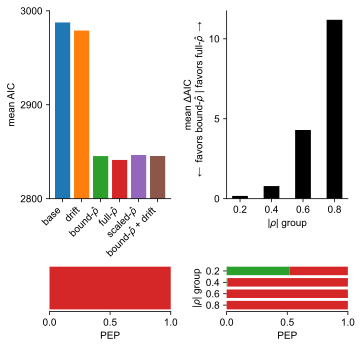

In [57]:
#Fig 6 (overall fit stats + broken down by rho cond)

#NOTE: w/ new size of this figure y-axis for delta AIC plot has to be manually adjusted to fit
with mpl.rc_context({'mathtext.fontset':'custom'}):

    fig,ax=plt.subplots(nrows=2,ncols=2, gridspec_kw={'height_ratios':[4,1]},layout='constrained')


    #plot AIC over all rho conds
    for m,l in shared_mods_bar.items():
        ax[0,0].bar(x=l,height=fits_shared_ave.loc[m,'mean_aic'])
    ax[0,0].set_ylim([2800,3000])
    ax[0,0].locator_params(nbins=3, axis='y')
    ax[0,0].set_ylabel('mean AIC')
    ax[0,0].set_xticks(ax[0,0].get_xticks(),shared_mods_bar.values(),rotation=45, ha='right')

    #plot PEP over all rho conds
    left = 0
    for m,l in shared_mods_bar.items():
        p=ax[1,0].barh(y=0,width=fits_shared_ave.loc[m,'PEP'],height=0.2,left=left)
        #print(l)
        left += fits_shared_ave.loc[m,'PEP']

    ax[1,0].set_yticks([])
    ax[1,0].set_xlim((0,1))
    ax[1,0].set_xticks((0,0.5,1))
    ax[1,0].set_xlabel('PEP')
    ax[1,0].spines['left'].set_visible(False)


    #aic by rho cond
    rho_mod_diff = fits_shared_ave_rho.loc[comp_mods,'delta_aic'].unstack(level='model')
    x = rho_mod_diff.index.get_level_values('rho_cond') #np.arange(rho_mod_diff.shape[0])  # the label locations
    
    width = comp_mod_widths[len(comp_mods)-1] #0.085  # the width of the bars
    multiplier = 0
    for mm, mdf in rho_mod_diff.items():
        offset = width * multiplier
        #rects = ax[0,1].bar([str(rrr) for rrr in x],mdf,color=mod_colors[mm])
        rects = ax[0,1].bar(x + offset, mdf, width, label=mdf.index,
                            color=mod_colors[mm] if len(comp_mods)>1 else 'k')
        multiplier += 1
    #ax[0,1].axhline(0,linestyle=':',color='k',alpha=0.5)
    ax[0,1].set_xlabel(r'$|\rho|$ group')
    ax[0,1].set_ylabel(r'''mean $\Delta$AIC
    $\leftarrow$ favors bound-$\hat{\rho}$ | favors full-$\hat{\rho}$ $\rightarrow$''',ha='center')
    ax[0,1].set_xticks(x)
    ax[0,1].locator_params(nbins=3, axis='y')
    

    #pep by rho cond
    left = np.zeros(4)
    for m,l in shared_mods_bar.items():
        p=ax[1,1].barh(y=rho_conds,width=fits_shared_ave_rho.loc[m,'PEP'],height=0.15,left=left)
        #print(l)
        #ax[0,0].bar_label(p, label_type='center')
        left += fits_shared_ave_rho.loc[m,'PEP']
    ax[1,1].set_yticks(rho_conds)
    ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
    ax[1,1].set_ylabel(r'$|\rho|$ group')
    ax[1,1].set_xticks((0,0.5,1.0))
    ax[1,1].set_xlim((0,1))
    ax[1,1].set_xlabel('PEP')
    ax[1,1].spines['left'].set_visible(False)

    fig.set_figwidth(12.5*cm)
    fig.set_figheight(12*cm)

    fig.savefig(path.join(fig_dir,'fig6_fit_stats_%s.pdf' % date.today()))

## parameters

In [58]:
#Add column for best-fit params based on rho cond (as in model plots above)
if 'best' not in params_shared.index.get_level_values('model'):
    params_shared = params_shared.copy()

    best_params = params_shared.loc[idx[:,'bound_rscaleCLT_vrh',:,:],:].rename(index={'bound_rscaleCLT_vrh':'best'})

    display(best_params)
    display(best_params.index.get_level_values('rho_cond').unique())
    display(best_params.index.get_level_values('model').unique())

    params_shared = pd.concat([params_shared,best_params]).sort_index()
    
    assert params_shared.loc[idx[:,'bound_rscaleCLT_vrh',:,:],:].droplevel('model').equals(params_shared.loc[idx[:,'best',:,:],:].droplevel('model'))

    display(params_shared)


value hit_boundary
rho_cond model subject                  param                               
0.2      best  5bd781291fd7c80001bb1fad B0             1.905458        False
                                        Rn            -0.189192        False
                                        Rp             0.094776        False
                                        driftSNR0     25.380829        False
                                        nondectime     0.742958        False
...                                                         ...          ...
0.8      best  614fc66c9094c0a205c09a69 Rp             0.380045        False
                                        driftSNR0     15.165209        False
                                        nondectime     0.646673        False
                                        t              0.225167        False
                                        umixturecoef   0.010009        False

[700 rows x 2 columns]

Float64Index([0.2, 0.4, 0.6, 0.8], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value  \
rho_cond model      subject                  param                     
0.2      best       5bd781291fd7c80001bb1fad B0             1.905458   
                                             Rn            -0.189192   
                                             Rp             0.094776   
                                             driftSNR0     25.380829   
                                             nondectime     0.742958   
...                                                              ...   
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0             2.557039   
                                             driftSNR0     18.014921   
                                             nondectime     0.583738   
                                             t              0.460736   
                                             umixturecoef   0.126063   

                                                          hit_boundary  
rho_cond model      subject                  param                      
0.2      best       5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[5100 rows x 2 columns]

In [59]:
#average over participants

params_shared_ave = \
    params_shared.drop(['hit_boundary'],axis=1).groupby(['model','rho_cond','param']).agg(['mean','std','sem'])
display(params_shared_ave)

value                    
                                       mean       std       sem
model      rho_cond param                                      
best       0.2      B0             1.776903  0.529857  0.105971
                    Rn            -0.150082  0.054657  0.010931
                    Rp             0.132486  0.080485  0.016097
                    driftSNR0     17.488190  3.522121  0.704424
                    nondectime     0.326392  0.163556  0.032711
...                                     ...       ...       ...
rsharedCLT 0.8      B0             1.778922  0.490145  0.098029
                    driftSNR0     20.303667  3.089487  0.617897
                    nondectime     0.359283  0.171029  0.034206
                    t              0.213635  0.130016  0.026003
                    umixturecoef   0.119047  0.048949  0.009790

[204 rows x 3 columns]

### paper plots (using best model for primary analyses)
If you want plots for a different model with correlation parameters, change the param_plot_model variable below.

In [60]:
#first lets plot the Rn/Rp params across all rho_conds
param_plot_model = 'best'


#also do for subject-level (I'm doing this in reverse order from usual but whatever)
rho_params_subj = params_shared.loc[idx[:,param_plot_model,:,['Rn','Rp']],['value']].droplevel('model',axis=0).copy()
rho_params_subj['rho'] = rho_params_subj.index.get_level_values('rho_cond')
rho_params_subj['rho']*=2*(rho_params_subj.index.get_level_values('param')=='Rp')-1
display(rho_params_subj)

#also do for average level (need to do things a littel differently here b/c want to average in z space)
rho_params=rho_params_subj.groupby(['rho_cond','param','rho'])[['value']].agg([meanzr,sem_low,sem_high])
rho_params=rho_params.rename(columns={'meanzr':'mean'},level=1).reset_index(level='rho') #clean up
display(rho_params)

value  rho
rho_cond subject                  param               
0.2      5bd781291fd7c80001bb1fad Rn    -0.189192 -0.2
                                  Rp     0.094776  0.2
         5d645bf6912c630018e269e3 Rn    -0.050097 -0.2
                                  Rp     0.300510  0.2
         5e705a1be6c65a62c56a3143 Rn    -0.203321 -0.2
...                                           ...  ...
0.8      613ab15693299c16c27d8c92 Rp     0.414264  0.8
         613da525a95f61825e2c6b68 Rn    -0.660381 -0.8
                                  Rp     0.634759  0.8
         614fc66c9094c0a205c09a69 Rn    -0.714688 -0.8
                                  Rp     0.380045  0.8

[200 rows x 2 columns]

rho     value                    
                         mean   sem_low  sem_high
rho_cond param                                   
0.2      Rn    -0.2 -0.150515  0.010921  0.010957
         Rp     0.2  0.133330  0.016205  0.016134
0.4      Rn    -0.4 -0.318282  0.013271  0.013397
         Rp     0.4  0.269316  0.016156  0.016006
0.6      Rn    -0.6 -0.488280  0.009974  0.010103
         Rp     0.6  0.454757  0.026454  0.025675
0.8      Rn    -0.8 -0.699789  0.009453  0.009704
         Rp     0.8  0.550791  0.028850  0.027591

In [61]:
#compute bound scale factor (deviation)
rho_params_subj['scale_dev'] = np.sqrt(1+rho_params_subj['value'])/np.sqrt(1+rho_params_subj['rho'])

##should this be averaged over scale or rho???? (based on the rho average, which seems OK given previous plot?)
rho_params['scale_dev'] = np.sqrt(1+rho_params[('value','mean')])/np.sqrt(1+rho_params['rho'])

#compute naive line (don't take correlation into account)
param_rho_xlim = [-0.85,0.85]
param_rho_xrange = np.linspace(param_rho_xlim[0],param_rho_xlim[1],500)
param_rho_naive = 1/np.sqrt(1+param_rho_xrange)

In [62]:
#save out rho params for analysis
if False:
    rho_params_subj.to_csv(path.join(data_dir,'rho_params_best_%s.csv' % date.today()),index=True)
    
#also save out all params for best model
if False:
    params_shared.xs('best',level='model')[['value']].to_csv(path.join(data_dir,'params_best_%s.csv' % date.today()),index=True)

In [63]:
params_shared

value  \
rho_cond model      subject                  param                     
0.2      best       5bd781291fd7c80001bb1fad B0             1.905458   
                                             Rn            -0.189192   
                                             Rp             0.094776   
                                             driftSNR0     25.380829   
                                             nondectime     0.742958   
...                                                              ...   
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0             2.557039   
                                             driftSNR0     18.014921   
                                             nondectime     0.583738   
                                             t              0.460736   
                                             umixturecoef   0.126063   

                                                          hit_boundary  
rho_cond model      subject                  param                      
0.2      best       5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[5100 rows x 2 columns]

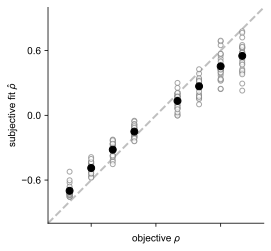

In [64]:
fig,ax=plt.subplots()
ax.axline((0, 0), slope=1,linestyle='--',color='grey',alpha=0.5,linewidth=2)

ax.plot(rho_params_subj['rho'],rho_params_subj['value'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)

ax.errorbar(rho_params['rho'],rho_params[('value','mean')],
            yerr=rho_params[[('value','sem_low'),('value','sem_high')]].to_numpy().T,
            linestyle='',marker='.',markersize=14,elinewidth=2,color='black')
ax.set_xticks([-0.6,0,0.6])# rho_params['rho'])
ax.set_xticklabels([])
ax.set_yticks([-0.6,0,0.6])#rho_params['rho'])
ax.set_ylim((-1,1))
ax.set_xlim((-1,1))
ax.set_xlabel(r'objective $\rho$')
ax.set_ylabel(r'subjective fit $\hat{\rho}$')
fig.set_figwidth(9.85*cm)
ax.set_aspect('equal')
fig.savefig(path.join(fig_dir,'fig6_top_%s_%s.pdf' % (param_plot_model,date.today())))

#### parameter tables

Generate and save tables for all models for inclusion in ms

In [65]:
for mm, mdf in params_shared_ave.drop('best',level='model').groupby('model'):
    
    mdf.columns = mdf.columns.droplevel(0)
    mdf = mdf.droplevel('model',axis=0)
    display(mdf)
    mdf.to_csv(path.join(path.join(data_dir,'param_tables','fits_ave_%s_%s.csv' % (mm,date.today()))),
               index=True,float_format='%.3f')    

mean       std       sem
rho_cond param                                      
0.2      B0             1.766423  0.527778  0.105556
         Rn            -0.130577  0.085041  0.017008
         Rp             0.108442  0.110895  0.022179
         driftSNR0     17.660340  3.689965  0.737993
         nondectime     0.335702  0.164490  0.032898
         t              0.126794  0.130865  0.026173
         umixturecoef   0.011963  0.009294  0.001859
0.4      B0             1.947539  0.702062  0.140412
         Rn            -0.284696  0.087876  0.017575
         Rp             0.245406  0.148674  0.029735
         driftSNR0     19.243845  4.762192  0.952438
         nondectime     0.402428  0.282297  0.056459
         t              0.124094  0.114406  0.022881
         umixturecoef   0.009528  0.010773  0.002155
0.6      B0             1.796463  0.509633  0.101927
         Rn            -0.484258  0.070497  0.014099
         Rp             0.443113  0.157683  0.031537
         driftSNR0     16.972401  3.263208  0.652642
         nondectime     0.267448  0.126031  0.025206
         t              0.087466  0.092785  0.018557
         umixturecoef   0.009301  0.007362  0.001472
0.8      B0             1.855919  0.479761  0.095952
         Rn            -0.684734  0.065181  0.013036
         Rp             0.493427  0.137389  0.027478
         driftSNR0     17.100465  2.769824  0.553965
         nondectime     0.284665  0.179080  0.035816
         t              0.105529  0.099134  0.019827
         umixturecoef   0.012796  0.014116  0.002823

mean       std       sem
rho_cond param                                      
0.2      B0             1.766089  0.525247  0.105049
         Rn            -0.126351  0.112295  0.022459
         Rp             0.144732  0.126590  0.025318
         driftSNR0     17.149083  3.279804  0.655961
         driftSNRn     17.360475  3.666437  0.733287
         driftSNRp     18.186210  3.631328  0.726266
         nondectime     0.340839  0.167251  0.033450
         t              0.127149  0.125775  0.025155
         umixturecoef   0.011928  0.009273  0.001855
0.4      B0             1.931482  0.705353  0.141071
         Rn            -0.314510  0.095035  0.019007
         Rp             0.275445  0.146465  0.029293
         driftSNR0     19.551385  4.923249  0.984650
         driftSNRn     18.643801  4.832606  0.966521
         driftSNRp     19.675810  4.530884  0.906177
         nondectime     0.418776  0.267985  0.053597
         t              0.123267  0.116137  0.023227
         umixturecoef   0.009990  0.008065  0.001613
0.6      B0             1.828565  0.547221  0.109444
         Rn            -0.518241  0.072137  0.014427
         Rp             0.418905  0.192759  0.038552
         driftSNR0     17.546838  3.282778  0.656556
         driftSNRn     14.911002  3.372404  0.674481
         driftSNRp     18.445627  4.074265  0.814853
         nondectime     0.270241  0.104183  0.020837
         t              0.092133  0.098392  0.019678
         umixturecoef   0.010944  0.010111  0.002022
0.8      B0             1.856153  0.484386  0.096877
         Rn            -0.703486  0.049764  0.009953
         Rp             0.554146  0.153663  0.030733
         driftSNR0     18.572245  3.459222  0.691844
         driftSNRn     14.138136  2.880530  0.576106
         driftSNRp     20.278587  3.632328  0.726466
         nondectime     0.298470  0.165789  0.033158
         t              0.106394  0.097599  0.019520
         umixturecoef   0.013054  0.015136  0.003027

mean       std       sem
rho_cond param                                      
0.2      B0             1.794626  0.529462  0.105892
         Rn            -0.012975  0.256315  0.051263
         RnB           -0.098363  0.087505  0.017501
         Rp             0.221724  0.284456  0.056891
         RpB            0.161234  0.140106  0.028021
         driftSNR0     17.898164  3.808279  0.761656
         nondectime     0.324086  0.162423  0.032485
         t              0.130234  0.125504  0.025101
         umixturecoef   0.012997  0.010750  0.002150
0.4      B0             1.959043  0.701476  0.140295
         Rn            -0.276442  0.154576  0.030915
         RnB           -0.297686  0.082891  0.016578
         Rp             0.443001  0.277443  0.055489
         RpB            0.351065  0.121357  0.024271
         driftSNR0     19.716733  4.745207  0.949041
         nondectime     0.400375  0.278991  0.055798
         t              0.130108  0.117813  0.023563
         umixturecoef   0.011170  0.012307  0.002461
0.6      B0             1.819900  0.535085  0.107017
         Rn            -0.328293  0.161432  0.032286
         RnB           -0.430893  0.078129  0.015626
         Rp             0.463906  0.239609  0.047922
         RpB            0.451653  0.101083  0.020217
         driftSNR0     17.918247  3.650871  0.730174
         nondectime     0.259533  0.108783  0.021757
         t              0.091324  0.092463  0.018493
         umixturecoef   0.012107  0.014219  0.002844
0.8      B0             1.870340  0.471245  0.094249
         Rn            -0.622732  0.162150  0.032430
         RnB           -0.677185  0.070399  0.014080
         Rp             0.410490  0.262147  0.052429
         RpB            0.482682  0.159901  0.031980
         driftSNR0     18.066400  3.262310  0.652462
         nondectime     0.285784  0.177237  0.035447
         t              0.109462  0.100070  0.020014
         umixturecoef   0.013272  0.015121  0.003024

mean       std       sem
rho_cond param                                      
0.2      B0             1.776903  0.529857  0.105971
         Rn            -0.150082  0.054657  0.010931
         Rp             0.132486  0.080485  0.016097
         driftSNR0     17.488190  3.522121  0.704424
         nondectime     0.326392  0.163556  0.032711
         t              0.125684  0.123989  0.024798
         umixturecoef   0.010899  0.009677  0.001935
0.4      B0             1.966888  0.691735  0.138347
         Rn            -0.316744  0.065828  0.013166
         Rp             0.267557  0.080375  0.016075
         driftSNR0     19.400704  4.980893  0.996179
         nondectime     0.390082  0.290333  0.058067
         t              0.127993  0.111505  0.022301
         umixturecoef   0.007894  0.006827  0.001365
0.6      B0             1.803366  0.504534  0.100907
         Rn            -0.486733  0.049987  0.009997
         Rp             0.445390  0.122733  0.024547
         driftSNR0     17.620047  3.639106  0.727821
         nondectime     0.271558  0.110955  0.022191
         t              0.089122  0.097692  0.019538
         umixturecoef   0.010991  0.016375  0.003275
0.8      B0             1.821954  0.429021  0.085804
         Rn            -0.696717  0.052317  0.010463
         Rp             0.536178  0.138626  0.027725
         driftSNR0     18.182191  3.093850  0.618770
         nondectime     0.304705  0.174981  0.034996
         t              0.097092  0.095160  0.019032
         umixturecoef   0.010910  0.013518  0.002704

mean       std       sem
rho_cond param                                      
0.2      B0             1.772293  0.503743  0.100749
         driftSNR0     17.382149  3.729531  0.745906
         driftSNRn     18.122011  3.550897  0.710179
         driftSNRp     17.169431  3.529359  0.705872
         nondectime     0.332001  0.169641  0.033928
         t              0.127759  0.121261  0.024252
         umixturecoef   0.011267  0.008633  0.001727
0.4      B0             1.942226  0.669109  0.133822
         driftSNR0     19.081187  4.693241  0.938648
         driftSNRn     22.008243  5.514607  1.102921
         driftSNRp     17.750338  4.109160  0.821832
         nondectime     0.391766  0.273388  0.054678
         t              0.134834  0.116052  0.023210
         umixturecoef   0.013436  0.017043  0.003409
0.6      B0             1.818447  0.565785  0.113157
         driftSNR0     17.121659  3.122903  0.624581
         driftSNRn     21.591672  4.124527  0.824905
         driftSNRp     15.932409  2.926033  0.585207
         nondectime     0.248314  0.115161  0.023032
         t              0.127009  0.108246  0.021649
         umixturecoef   0.050216  0.044834  0.008967
0.8      B0             1.842787  0.476621  0.095324
         driftSNR0     18.429641  2.662152  0.532430
         driftSNRn     29.082277  8.611055  1.722211
         driftSNRp     17.300706  2.703047  0.540609
         nondectime     0.316127  0.189763  0.037953
         t              0.189561  0.126899  0.025380
         umixturecoef   0.115298  0.046516  0.009303

mean       std       sem
rho_cond param                                      
0.2      B0             1.775100  0.512816  0.102563
         driftSNR0     17.458159  3.404574  0.680915
         nondectime     0.327567  0.162017  0.032403
         t              0.127919  0.123161  0.024632
         umixturecoef   0.010610  0.008311  0.001662
0.4      B0             1.910929  0.644370  0.128874
         driftSNR0     19.543338  4.722686  0.944537
         nondectime     0.399308  0.284068  0.056814
         t              0.130769  0.109210  0.021842
         umixturecoef   0.013234  0.017829  0.003566
0.6      B0             1.791962  0.555983  0.111197
         driftSNR0     18.020968  3.301840  0.660368
         nondectime     0.263696  0.110244  0.022049
         t              0.128994  0.107697  0.021539
         umixturecoef   0.049406  0.043520  0.008704
0.8      B0             1.778922  0.490145  0.098029
         driftSNR0     20.303667  3.089487  0.617897
         nondectime     0.359283  0.171029  0.034206
         t              0.213635  0.130016  0.026003
         umixturecoef   0.119047  0.048949  0.009790

# examinging learning effects
Models fit separately on first and second half of the data. Used in Fig 8.

In [66]:
fit_half_dir = path.join(fit_dir,'half_fits')
half_mods = ['bound_rscaleCLT_vrh'] 
half = [1,2]

half_samps = {}
for rc in rho_conds:
    half_samps[rc] = {}
    for h in half:
        half_samps[rc][h],_ = \
            gdw.load_data(datat.loc[(datat.rho_cond==rc)].copy(),
                rt="RT",conds=['rho','mu'],
                verbose=False,debug=False,postproc=lambda x: helpers.split_postproc(x,h))
        
#quick and dirty gut check
assert np.all(np.array([len(x) for hd in half_samps.values() for x in hd.values()])==25), \
    "Incorrect number of subjects per corr!"

In [67]:
#get fit for all models
half_fits = {}
for rc in rho_conds:
    half_fits[rc] = {}
    for m in half_mods:
        half_fits[rc][m] = {}
        for h in half:
            half_fits[rc][m][h] = \
                gdw.load_models(path.join(fit_half_dir,'%s_*_r%s_h%d*_2025-01-??' % (m,rho_conds_filestring[rc],h)),
                                verbose=True)
            assert len(half_fits[rc][m][h])==len(half_samps[rc][h].keys()), "Incorrect number of models loaded!"
            half_fits[rc][m][h] = {f.subject:f for f in half_fits[rc][m][h]}

print(np.array([len(x) for x in half_fits.values()]))
print(np.array([len(y) for x in half_fits.values() for y in x.values()]))
print(np.array([len(z) for x in half_fits.values() for y in x.values() for z in y.values()]))

loaded models:
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_5f30ee4c383a0d56521f69c7_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_60fead47231209607137f36e_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_60fe1c233dd0ee9020efca7e_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_613a8ef513f5e9934f6f6fb3_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_613433e6d6d82dbdad53e847_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_5f3ee36d0306de1a411882a5_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_5f74fa0614255d15319ee076_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_6154b3a7e4bc93e1ce93c6bc_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_5f2de3a7b874e712ac7bc516_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May10_r02_h1_h1_5ef37588bfe86a0ca12ba515_2025-01-03
./data/fits/half_fits/bound_rscaleCLT_vrh_May

In [68]:
#let's actually get params first so we can check on boundary issues before going to the trouble of solving

params_half = []
for rc,fdict in half_fits.items():
    print(rc)
    for m,hdict in fdict.items():
        print(m)
        for h,fits in hdict.items():
            print(h)
            #print(fits)
            if len(fits) > 0:
                parami = ddm_corr.get_all_params(fits)
                parami['rho_cond'] = rc
                parami['model'] = m
                parami['half'] = h
                params_half.append(parami)
    
params_half = pd.concat(params_half)
params_half.set_index(['rho_cond','model','half','subject'],inplace=True,append=True)
params_half = params_half.reorder_levels(['rho_cond','model','half','subject','param'])
params_half.sort_index(inplace=True)

0.2
bound_rscaleCLT_vrh
1
               value hit_boundary                   subject
param                                                      
driftSNR0  12.348973        False  5f30ee4c383a0d56521f69c7
Rn         -0.154636        False  5f30ee4c383a0d56521f69c7
Rp          0.166053        False  5f30ee4c383a0d56521f69c7
B0          1.838590        False  5f30ee4c383a0d56521f69c7
t           0.018096         True  5f30ee4c383a0d56521f69c7
                 value hit_boundary                   subject
param                                                        
t             0.018096         True  5f30ee4c383a0d56521f69c7
umixturecoef  0.001000         True  5f30ee4c383a0d56521f69c7
umixturecoef  0.001000         True  613a8ef513f5e9934f6f6fb3
umixturecoef  0.001000         True  5ef37588bfe86a0ca12ba515
t             0.048755         True  616f469494656434f5b4ebc6
nondectime    0.023856         True  616f469494656434f5b4ebc6
umixturecoef  0.001000         True  616f469494656434f5b4e

In [69]:
#some sanity checks
assert np.all(params_half.xs('t',level='param').groupby(['model','rho_cond','half']).size().to_numpy()==25), \
    "Wrong number of subjects per model in params"
assert len(params_half.xs('t',level='param').groupby(['model','rho_cond','half']).size())==\
    len(rho_conds)*len(half_mods)*len(half), \
    "Wrong number of model/rho cond combinations in params"

#first pass check for any problematic fits re: param bounds
display(params_half.loc[params_half.hit_boundary].groupby('param').hit_boundary.value_counts())
display(params_half.loc[params_half.hit_boundary].groupby('param').min())
display(params_half.loc[params_half.hit_boundary].groupby('param').max())

param         hit_boundary
nondectime    True             6
t             True            67
umixturecoef  True            79
Name: hit_boundary, dtype: int64

,value,hit_boundary
param,,
nondectime,0.002141,True
t,0.000000,True
umixturecoef,0.001000,True


,value,hit_boundary
param,,
nondectime,0.029930,True
t,0.057995,True
umixturecoef,0.003939,True


In [70]:
do_sols = False
if do_sols:
    half_soldf = []
    #half_soldf = {k:{} for k in half_mods}
    for (sk,sv),(mk,mv) in zip(half_samps.items(),half_fits.items()):
        assert sk==mk
        print(sk)
        for mmk,mmv in mv.items():
            print(mmk)
            #half_soldf[mmk][sk] = {}
            for (shk,shv),(mmhk,mmhv) in zip(sv.items(),mmv.items()):
                assert shk==mmhk
                print(shk)
                
                soldf = ddm_corr.get_all_sols(shv,mmhv)
                #soldf = {}
                soldf['rho_cond'] = sk
                soldf['model'] = mmk
                soldf['half'] = shk
                print(soldf)
                
                half_soldf.append(soldf)
                #half_soldf[mmk][sk][shk] = soldf
                
    with open(path.join(fit_half_dir,'half_sols_%s' % date.today()),'wb') as f:
             pickle.dump(half_soldf,f)
else:
    with open(path.join(fit_half_dir,'half_sols_2025-01-04'),'rb') as f:
        half_soldf = pickle.load(f)
        
        
half_soldf = pd.concat(half_soldf,ignore_index=True).set_index(['model','subject','rho_cond','half'])

#some quick sanity checks
assert np.all(half_soldf.value_counts(['model','subject','half'])==12), 'Incorrect number of conditions per fit!'
assert np.array_equal(half_soldf.index.unique('subject').sort_values(),subj.subject), 'Subject fits missing!'
assert len(half_soldf)==3*2*2*len(half_mods)*2*100, 'Incorrect number of total predictions!'

half_soldf

rho       mu  \
model               subject                  rho_cond half                 
bound_rscaleCLT_vrh 5f30ee4c383a0d56521f69c7 0.2      1     0.0 -0.02818   
                                                      1     0.2 -0.03088   
                                                      1     0.2 -0.07719   
                                                      1    -0.2  0.06302   
                                                      1    -0.2 -0.02521   
...                                                         ...      ...   
                    612eb19f8a38f5cbf48d287a 0.8      2     0.0 -0.05229   
                                                      2     0.8 -0.02806   
                                                      2     0.0 -0.02092   
                                                      2    -0.8 -0.02339   
                                                      2     0.8  0.02806   

                                                            mean_corr  \
model               subject                  rho_cond half              
bound_rscaleCLT_vrh 5f30ee4c383a0d56521f69c7 0.2      1      0.776508   
                                                      1      0.776928   
                                                      1      0.958553   
                                                      1      0.958475   
                                                      1      0.776513   
...                                                               ...   
                    612eb19f8a38f5cbf48d287a 0.8      2      0.889004   
                                                      2      0.697710   
                                                      2      0.696190   
                                                      2      0.887407   
                                                      2      0.697710   

                                                            mean_err  \
model               subject                  rho_cond half             
bound_rscaleCLT_vrh 5f30ee4c383a0d56521f69c7 0.2      1     0.223492   
                                                      1     0.223072   
                                                      1     0.041447   
                                                      1     0.041525   
                                                      1     0.223487   
...                                                              ...   
                    612eb19f8a38f5cbf48d287a 0.8      2     0.110996   
                                                      2     0.302290   
                                                      2     0.303810   
                                                      2     0.112593   
                                                      2     0.302290   

                                                            mean_RT_corr  \
model               subject                  rho_cond half                 
bound_rscaleCLT_vrh 5f30ee4c383a0d56521f69c7 0.2      1         3.251569   
                                                      1         3.180108   
                                                      1         2.273123   
                                                      1         2.433945   
                                                      1         3.408492   
...                                                                  ...   
                    612eb19f8a38f5cbf48d287a 0.8      2         1.415598   
                                                      2         1.260781   
                                                      2         1.680429   
                                                      2         1.765999   
                                                      2         1.260781   

                                                            mean_undec  \
model               subject                  rho_cond half               
bound_rscaleCLT_vrh 5f30ee4c383a0d56521f69c7 0.

In [71]:
#need to split data in half for merging urg, also slightly janky
datat_half = {h:datat.groupby('subject'
                           ,sort=False,as_index=False,group_keys=False).apply(lambda x: helpers.split_postproc(x,h))
              for h in half}
for k,v in datat_half.items():
    v['half'] = k
    
datat_half = pd.concat(datat_half.values())
datat_half

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR,half
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14,1
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2,-0.89,1
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2,-0.14,1
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2,0.14,1
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2,-0.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
76752,764,5e95d4f551598d01d6d455af,-0.8,-0.00788,3.7340,0.0,1.0,-0.124189,0.310849,0.8,-0.12,2
76753,765,5e95d4f551598d01d6d455af,0.8,0.05914,1.1230,1.0,1.0,0.777231,0.310849,0.8,0.78,2
76754,766,5e95d4f551598d01d6d455af,-0.8,0.00788,4.8250,0.0,0.0,0.124189,0.310849,0.8,0.12,2
76755,767,5e95d4f551598d01d6d455af,0.8,-0.05914,0.4020,0.0,1.0,-0.777231,0.310849,0.8,-0.78,2


In [72]:
#combine predictions w/ data
    
datat_mhalf_dict = {m:ddm_corr.data_pred_merge(datat_half,sols,on=['subject','half','rho_cond','rho','mu']) 
                 for m,sols in half_soldf.groupby('model')}




   trial                   subject  rho       mu      RT  response  correct  \
0      1  5f3ee36d0306de1a411882a5  0.2  0.02069  1.6825       1.0      1.0   
1     18  5f3ee36d0306de1a411882a5  0.2  0.02069  2.9287       1.0      1.0   
2     36  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6330       0.0      0.0   
3     40  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6890       1.0      1.0   
4     59  5f3ee36d0306de1a411882a5  0.2  0.02069  1.7222       0.0      0.0   

     SNRraw  threshold  rho_cond   SNR  half  mean_corr  mean_err  \
0  0.142692   0.356901       0.2  0.14     1   0.727973  0.272027   
1  0.142692   0.356901       0.2  0.14     1   0.727973  0.272027   
2  0.142692   0.356901       0.2  0.14     1   0.727973  0.272027   
3  0.142692   0.356901       0.2  0.14     1   0.727973  0.272027   
4  0.142692   0.356901       0.2  0.14     1   0.727973  0.272027   

   mean_RT_corr  mean_RT_err  pred_response  
0      2.991749     3.255046       0.727973  
1      2.991749   

In [73]:
#bind all predictions into one df

assert len(half_mods) in [1,2], "Code only set to handle one or two half models!"

if len(half_mods)==2:
    datat_mhalf = datat_mhalf_dict[half_mods[0]].drop(['mean_corr','mean_err'],axis=1).merge(
        datat_mhalf_dict[half_mods[1]][['rho_cond','subject','half','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                             on=['rho_cond','subject','half','trial'],
                                                            suffixes=('_'+x for x in half_mods),
                                                              validate='1:1')
else:
    datat_mhalf = datat_mhalf_dict[half_mods[0]]
    half_col_n0 = ['pred_response','mean_RT_corr','mean_RT_err']
    half_col_n1 = [x+'_'+half_mods[0] for x in half_col_n0]
    datat_mhalf = datat_mhalf.drop(['mean_corr','mean_err'],axis=1).rename(columns=dict(zip(half_col_n0,half_col_n1)))   

datat_mhalf

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR,half,mean_RT_corr_bound_rscaleCLT_vrh,mean_RT_err_bound_rscaleCLT_vrh,pred_response_bound_rscaleCLT_vrh
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76113,719,5e95d4f551598d01d6d455af,0.8,0.05914,0.6540,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.401272,2.117011,0.878705
76114,727,5e95d4f551598d01d6d455af,0.8,0.05914,0.6460,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.401272,2.117011,0.878705
76115,733,5e95d4f551598d01d6d455af,0.8,0.05914,0.5190,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.401272,2.117011,0.878705
76116,745,5e95d4f551598d01d6d455af,0.8,0.05914,1.3880,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.401272,2.117011,0.878705


In [74]:
#add best model cols

datat_mhalf['mean_RT_corr_best'] = datat_mhalf['mean_RT_corr_bound_rscaleCLT_vrh']
assert datat_mhalf['mean_RT_corr_bound_rscaleCLT_vrh'].equals(\
    datat_mhalf['mean_RT_corr_best'])

datat_mhalf['mean_RT_err_best'] = datat_mhalf['mean_RT_err_bound_rscaleCLT_vrh']
assert datat_mhalf['mean_RT_err_bound_rscaleCLT_vrh'].equals(\
    datat_mhalf['mean_RT_err_best'])

datat_mhalf['pred_response_best'] = datat_mhalf['pred_response_bound_rscaleCLT_vrh']
assert datat_mhalf['pred_response_bound_rscaleCLT_vrh'].equals(\
    datat_mhalf['pred_response_best'])

display(datat_mhalf.head())

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR,half,mean_RT_corr_bound_rscaleCLT_vrh,mean_RT_err_bound_rscaleCLT_vrh,pred_response_bound_rscaleCLT_vrh,mean_RT_corr_best,mean_RT_err_best,pred_response_best
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973,2.991749,3.255046,0.727973
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973,2.991749,3.255046,0.727973
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973,2.991749,3.255046,0.727973
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973,2.991749,3.255046,0.727973
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,0.14,1,2.991749,3.255046,0.727973,2.991749,3.255046,0.727973


In [75]:
#average for plotting

mod_cols_resp = ['_'.join(x) for x in product(['pred_response'],half_mods+['best'])]
mod_cols_RT = ['_'.join(x) for x in product(['mean_RT_corr','mean_RT_err'],half_mods+['best'])]
mod_cols_suffix = ['_'+x for x in half_mods]
mod_lines = [':','-',(0,(1,10)),(0,(5,10))]

datat_mhalf_psycho_ave = \
    datat_mhalf[['half','subject','rho_cond','rho','SNR','mu','response']+mod_cols_resp].groupby(['half','subject','rho_cond','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_mhalf_psycho_ave.groupby('rho_cond').head())

datat_mhalf_chrono_ave = \
    datat_mhalf[['half','subject','rho_cond','rho','SNR','mu','correct','RT']+mod_cols_RT].groupby(['half','subject','rho_cond','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_mhalf_chrono_ave.groupby('rho_cond').head())

response  \
                                                                mean   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.093750   
                                            -0.12 -0.01340  0.343750   
                                             0.12  0.01340  0.656250   
                                             0.75  0.03350  1.000000   
                                        0.0 -0.75 -0.04325  0.125000   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.071429   
                                            -0.12 -0.00759  0.500000   
                                             0.12  0.00759  0.812500   
                                             0.72  0.01897  0.968750   
                                        0.0 -0.72 -0.04241  0.000000   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.093750   
                                            -0.14 -0.01195  0.375000   
                                             0.14  0.01195  0.781250   
                                             0.89  0.02987  0.937500   
                                        0.0 -0.89 -0.04723  0.250000   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.031250   
                                            -0.13 -0.01606  0.312500   
                                             0.13  0.01606  0.687500   
                                             0.81  0.04015  0.968750   
                                        0.0 -0.81 -0.04489  0.000000   

                                                                      \
                                                                 std   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.296145   
                                            -0.12 -0.01340  0.482559   
                                             0.12  0.01340  0.482559   
                                             0.75  0.03350  0.000000   
                                        0.0 -0.75 -0.04325  0.336011   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.262265   
                                            -0.12 -0.00759  0.508001   
                                             0.12  0.00759  0.396558   
                                             0.72  0.01897  0.176777   
                                        0.0 -0.72 -0.04241  0.000000   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.296145   
                                            -0.14 -0.01195  0.491869   
                                             0.14  0.01195  0.420013   
                                             0.89  0.02987  0.245935   
                                        0.0 -0.89 -0.04723  0.439941   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.176777   
                                            -0.13 -0.01606  0.470929   
                                             0.13  0.01606  0.470929   
                                             0.81  0.04015  0.176777   
                                        0.0 -0.81 -0.04489  0.000000   

                                                                      \
                                                                 sem   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.052351   
                                            -0.12 -0.01340  0.085305   
                                             0.12  0.01340  0.085305   
                                             0.75  0.03350  0.000000   
                                        0.0 -0.75 -0.04325  0.059399   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.049563   
                                            -0.12 -0.00759  0.089803   
                          

RT  \
                                                                        mean   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      4.470033   
                                                           1.0      3.031555   
                                            -0.12 -0.01340 0.0      3.418855   
                                                           1.0      3.261429   
                                             0.12  0.01340 0.0      2.716700   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      5.342000   
                                                           1.0      3.715231   
                                            -0.12 -0.00759 0.0      3.892562   
                                                           1.0      3.164875   
                                             0.12  0.00759 0.0      3.270833   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      5.012700   
                                                           1.0      3.064517   
                                            -0.14 -0.01195 0.0      3.577833   
                                                           1.0      3.235625   
                                             0.14  0.01195 0.0      3.301386   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      1.814000   
                                                           1.0      2.096597   
                                            -0.13 -0.01606 0.0      2.553170   
                                                           1.0      2.058636   
                                             0.13  0.01606 0.0      2.354940   

                                                                              \
                                                                         std   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.968183   
                                                           1.0      0.814288   
                                            -0.12 -0.01340 0.0      1.361267   
                                                           1.0      1.007931   
                                             0.12  0.01340 0.0      0.989235   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      1.035204   
                                                           1.0      2.066398   
                                            -0.12 -0.00759 0.0      1.904362   
                                                           1.0      1.579585   
                                             0.12  0.00759 0.0      0.716746   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      4.018549   
                                                           1.0      1.040751   
                                            -0.14 -0.01195 0.0      1.692593   
                                                           1.0      1.323437   
                                             0.14  0.01195 0.0      1.425381   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0           NaN   
                                                           1.0      0.744182   
                                            -0.13 -0.01606 0.0      0.724531   
                                                           1.0      0.453032   
                                             0.13  0.01606 0.0      0.730811   

                                                                              \
                                                                         sem   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.136331   
                                                           1.0      0.15

In [76]:
#average over Ss

datat_mhalf_psycho_ave_all = \
    datat_mhalf_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['half','rho_cond','rho','uSNR']).agg(['mean','std','sem'])
display(datat_mhalf_psycho_ave_all)

datat_mhalf_chrono_ave_all = \
    datat_mhalf_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['half','rho_cond','rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_mhalf_chrono_ave_all)


response                      \
                                mean       std       sem   
half rho_cond rho  uSNR                                    
1    0.2      -0.2 -0.9239  0.075501  0.059197  0.011839   
                   -0.1480  0.278694  0.118491  0.023698   
                    0.1480  0.766913  0.095366  0.019073   
                    0.9239  0.918548  0.065056  0.013011   
               0.0 -0.9239  0.095059  0.087140  0.017428   
...                              ...       ...       ...   
2    0.8       0.0  0.9239  0.933584  0.058862  0.011772   
               0.8 -0.9239  0.068018  0.061618  0.012324   
                   -0.1480  0.265459  0.106305  0.021261   
                    0.1480  0.782570  0.083074  0.016615   
                    0.9239  0.943000  0.058175  0.011635   

                           pred_response_bound_rscaleCLT_vrh            \
                                                        mean       std   
half rho_cond rho  uSNR                                                  
1    0.2      -0.2 -0.9239                          0.083533  0.043161   
                   -0.1480                          0.272407  0.044871   
                    0.1480                          0.727593  0.044871   
                    0.9239                          0.916467  0.043161   
               0.0 -0.9239                          0.082599  0.043142   
...                                                      ...       ...   
2    0.8       0.0  0.9239                          0.921550  0.044345   
               0.8 -0.9239                          0.075708  0.044037   
                   -0.1480                          0.259880  0.051178   
                    0.1480                          0.740120  0.051178   
                    0.9239                          0.924292  0.044037   

                                     pred_response_best                      \
                                 sem               mean       std       sem   
half rho_cond rho  uSNR                                                       
1    0.2      -0.2 -0.9239  0.008632           0.083533  0.043161  0.008632   
                   -0.1480  0.008974           0.272407  0.044871  0.008974   
                    0.1480  0.008974           0.727593  0.044871  0.008974   
                    0.9239  0.008632           0.916467  0.043161  0.008632   
               0.0 -0.9239  0.008628           0.082599  0.043142  0.008628   
...                              ...                ...       ...       ...   
2    0.8       0.0  0.9239  0.008869           0.921550  0.044345  0.008869   
               0.8 -0.9239  0.008807           0.075708  0.044037  0.008807   
                   -0.1480  0.010236           0.259880  0.051178  0.010236   
                    0.1480  0.010236           0.740120  0.051178  0.010236   
                    0.9239  0.008807           0.924292  0.044037  0.008807   

                           rSNR             auSNR            
                           mean  std  sem    mean  std  sem  
half rho_cond rho  uSNR                                      
1    0.2      -0.2 -0.9239  1.0  0.0  0.0  0.9239  0.0  0.0  
                   -0.1480  2.0  0.0  0.0  0.1480  0.0  0.0  
                    0.1480  3.0  0.0  0.0  0.1480  0.0  0.0  
                    0.9239  4.0  0.0  0.0  0.9239  0.0  0.0  
               0.0 -0.9239  1.0  0.0  0.0  0.9239  0.0  0.0  
...                         ...  ...  ...     ...  ...  ...  
2    0.8       0.0  0.9239  4.0  0.0  0.0  0.9239  0.0  0.0  
               0.8 -0.9239  1.0  0.0  0.0  0.9239  0.0  0.0  
                   -0.1480  2.0  0.0  0.0  0.1480  0.0  0.0  
                    0.1480  3.0  0.0  0.0  0.1480  0.0  0.0  
                    0.9239  4.0  0.0  0.0  0.9239  0.0  0.0  

[96 rows x 15 columns]

RT                      \
                                        mean       std       sem   
half rho_cond rho  uSNR    correct                                 
1    0.2      -0.2 -0.9239 0.0      2.490349  1.071486  0.228442   
                           1.0      2.472659  0.795742  0.159148   
                   -0.1480 0.0      3.104484  1.425962  0.285192   
                           1.0      2.930832  1.117412  0.223482   
                    0.1480 0.0      3.005102  1.459225  0.291845   
...                                      ...       ...       ...   
2    0.8       0.8 -0.1480 1.0      2.020812  0.780153  0.156031   
                    0.1480 0.0      2.194926  1.324711  0.264942   
                           1.0      1.985825  0.897575  0.179515   
                    0.9239 0.0      1.528097  1.057563  0.236478   
                           1.0      1.558976  0.493937  0.098787   

                                   mean_RT_corr_bound_rscaleCLT_vrh            \
                                                               mean       std   
half rho_cond rho  uSNR    correct                                              
1    0.2      -0.2 -0.9239 0.0                             2.277529  0.702561   
                           1.0                             2.344670  0.699211   
                   -0.1480 0.0                             2.942108  0.994154   
                           1.0                             2.942108  0.994154   
                    0.1480 0.0                             2.942108  0.994154   
...                                                             ...       ...   
2    0.8       0.8 -0.1480 1.0                             2.049801  0.775513   
                    0.1480 0.0                             2.049801  0.775513   
                           1.0                             2.049801  0.775513   
                    0.9239 0.0                             1.542904  0.499480   
                           1.0                             1.578342  0.489972   

                                             mean_RT_corr_best            \
                                         sem              mean       std   
half rho_cond rho  uSNR    correct                                         
1    0.2      -0.2 -0.9239 0.0      0.149786          2.277529  0.702561   
                           1.0      0.139842          2.344670  0.699211   
                   -0.1480 0.0      0.198831          2.942108  0.994154   
                           1.0      0.198831          2.942108  0.994154   
                    0.1480 0.0      0.198831          2.942108  0.994154   
...                                      ...               ...       ...   
2    0.8       0.8 -0.1480 1.0      0.155103          2.049801  0.775513   
                    0.1480 0.0      0.155103          2.049801  0.775513   
                           1.0      0.155103          2.049801  0.775513   
                    0.9239 0.0      0.111687          1.542904  0.499480   
                           1.0      0.097994          1.578342  0.489972   

                                             mean_RT_err_bound_rscaleCLT_vrh  \
                                         sem                            mean   
half rho_cond rho  uSNR    correct                                             
1    0.2      -0.2 -0.9239 0.0      0.149786                        2.946403   
                           1.0      0.139842                        3.107748   
                   -0.1480 0.0      0.198831                        3.194156   
                           1.0      0.198831                        3.194156   
                    0.1480 0.0      0.198831                        3.194156   
...                                      ...                             ...   
2    0.8       0.8 -0.1480 1.0      0.155103                        2.223859   
                    0.1480 0.0      0.155103                        2.223859   
         

7.086614173228346
4.133858267716535
7.086614173228346
4.133858267716535


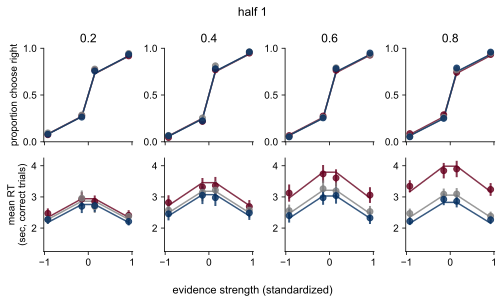

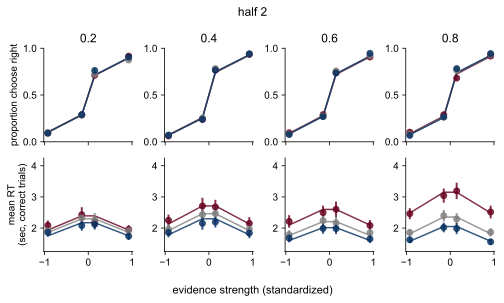

In [77]:
#horizontal version. 
cm = 1/2.54  # centimeters in inches

for h in half:

    fig,ax=plt.subplots(nrows=2,ncols=4)
    #then plot best fit model only against data separately per corr cond
    for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,datat_mhalf_psycho_ave_all.loc[h].groupby('rho_cond'),
                                   datat_mhalf_chrono_ave_all.loc[h].groupby('rho_cond')):
        assert rcp==rcc
        #print(rcp)
        dfp_r.reset_index(level='rho_cond',drop=True,inplace=True)
        dfc_r.reset_index(level='rho_cond',drop=True,inplace=True)
        plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix='_best',
                                       alpha=0.8,RT_err=False,ax=axi,ax_labels=False)
        axi[0].set_ylim((0,1))
        axi[0].set_xticklabels([])
        axi[0].set_yticks([0,0.5,1])
        axi[0].set_title(rcp)
        axi[0].legend().set_visible(False)
        #axi[1].set_yticks([2,3])
        axi[1].set_xticks([-1.0,0.0,1.0])

        axi[1].locator_params(nbins=3, axis='y')
        axi[1].set_ylim((1.25,4.25))
        ##set_size(6,3,axi[0])
        ##set_size(6,3,axi[1])

    #     for axii in axi:
    #         axii.spines['top'].set_visible(False)
    #         axii.spines['right'].set_visible(False)

    fig.supxlabel('evidence strength (standardized)')
    ax[0,0].set_ylabel('proportion choose right')
    ax[1,0].set_ylabel('mean RT\n(sec, correct trials)')
    fig.suptitle('half %d' % h)
    fig.set_figwidth(18*cm)
    fig.set_figheight(21*cm/2)
    fig.tight_layout()

    print(fig.get_figwidth())
    print(fig.get_figheight())

## parameters

In [78]:
#Add column for best-fit params based on rho cond (as in model plots above)
if 'best' not in params_half.index.get_level_values('model'):
    params_half = params_half.copy()

    best_params = params_half.loc[idx[:,'bound_rscaleCLT_vrh',:,:],:].rename(index={'bound_rscaleCLT_vrh':'best'})

    display(best_params)
    display(best_params.index.get_level_values('rho_cond').unique())
    display(best_params.index.get_level_values('model').unique())

    params_half = pd.concat([params_half,best_params]).sort_index()
    
    assert params_half.loc[idx[:,'bound_rscaleCLT_vrh',:,:],:].droplevel('model').equals(params_half.loc[idx[:,'best',:,:],:].droplevel('model'))

    display(params_half)

value  \
rho_cond model half subject                  param                     
0.2      best  1    5bd781291fd7c80001bb1fad B0             1.868499   
                                             Rn            -0.055730   
                                             Rp             0.123129   
                                             driftSNR0     25.987986   
                                             nondectime     0.759145   
...                                                              ...   
0.8      best  2    614fc66c9094c0a205c09a69 Rp             0.304827   
                                             driftSNR0     17.103482   
                                             nondectime     0.648166   
                                             t              0.310212   
                                             umixturecoef   0.012309   

                                                          hit_boundary  
rho_cond model half subject                  param                      
0.2      best  1    5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.8      best  2    614fc66c9094c0a205c09a69 Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[1400 rows x 2 columns]

Float64Index([0.2, 0.4, 0.6, 0.8], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value  \
rho_cond model               half subject                  param                     
0.2      best                1    5bd781291fd7c80001bb1fad B0             1.868499   
                                                           Rn            -0.055730   
                                                           Rp             0.123129   
                                                           driftSNR0     25.987986   
                                                           nondectime     0.759145   
...                                                                            ...   
0.8      bound_rscaleCLT_vrh 2    614fc66c9094c0a205c09a69 Rp             0.304827   
                                                           driftSNR0     17.103482   
                                                           nondectime     0.648166   
                                                           t              0.310212   
                                                           umixturecoef   0.012309   

                                                                        hit_boundary  
rho_cond model               half subject                  param                      
0.2      best                1    5bd781291fd7c80001bb1fad B0                  False  
                                                           Rn                  False  
                                                           Rp                  False  
                                                           driftSNR0           False  
                                                           nondectime          False  
...                                                                              ...  
0.8      bound_rscaleCLT_vrh 2    614fc66c9094c0a205c09a69 Rp                  False  
                                                           driftSNR0           False  
                                                           nondectime          False  
                                                           t                   False  
                                                           umixturecoef        False  

[2800 rows x 2 columns]

In [79]:
#compute scale dev for rho params and save params for analysis
rho_params_half_subj = params_half.loc[idx[:,'best',:,:,['Rn','Rp']],['value']].droplevel('model',axis=0).copy()
rho_params_half_subj['rho'] = rho_params_half_subj.index.get_level_values('rho_cond')
rho_params_half_subj['rho']*=2*(rho_params_half_subj.index.get_level_values('param')=='Rp')-1
rho_params_half_subj['scale_dev'] = np.sqrt(1+rho_params_half_subj['value'])/np.sqrt(1+rho_params_half_subj['rho'])

#save out rho params for analysis
if False:
    rho_params_half_subj.to_csv(path.join(data_dir,'rho_params_half_best_%s.csv' % date.today()),index=True)
    
#also save out all params for best model
if False:
    params_half.xs('best',level='model')[['value']].to_csv(path.join(data_dir,'params_half_best_%s.csv' % date.today()),index=True)